## Introduction

Peer-to-peer (P2P) lending represents an innovative method of peer-to-peer money lending, facilitated through online platforms. This study employs real-world data obtained from "Lending Club," an American-based company, to predict credit solvency(Binary Classification) using various predictive models and techniques, including Lasso, Ridge, Elastic-Net, Logistic Regression, Extreme Gradient Boosting, and Bayesian Additive Regression Trees (BART). Through an economic evaluation of the context and the results obtained from the models, this study aims to draw conclusions regarding credit risk assessment in the P2P lending market.

The original data set is large: 1.6 GB csv file. It was scraped from the Lending Club website by some guy on github.
We downloaded it from kaggle:
 https://www.kaggle.com/datasets/wordsforthewise/lending-club?select=accepted_2007_to_2018Q4.csv.gz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 150

In [2]:
path= "C:\\Users\\giuse\\OneDrive\\Desktop\\uni venezia\\terzo periodo\\models and technologies for the financial industry\\lending_club_large\\accepted_2007_to_2018q4.csv\\accepted_2007_to_2018Q4.csv"
df = pd.read_csv(path, low_memory = False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB
None


Before dropping the columns that contain information about loan payments, we calculate the average payment for a defaulted loan as a percentage of loan principal

In [3]:
default_pymnt_pct = (df.total_pymnt/df.loan_amnt)[df.loan_status.isin(['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off'])].mean()
default_pymnt_pct

0.54123379101107

On average loans that default pay back 54% of the principal

We also calculate the average payment as percentage of loan amount for loans that did not default

In [4]:
non_default_pymnt_pct = (df.total_pymnt/df.loan_amnt)[~df.loan_status.isin(['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off',"Current"])].mean()
print(non_default_pymnt_pct)
(1-default_pymnt_pct)/(non_default_pymnt_pct-1)


1.1378077260616586


3.3290311225632343

We see that on average to make up for the payment losses of one defaulted loan 3.33 non defaulted loans are needed

In [5]:
#selecting the variables of our interest
cols_to_keep = [
    "annual_inc","application_type","dti","earliest_cr_line","emp_length","fico_range_high","fico_range_low","grade",
    "home_ownership","inq_last_6mths","installment","int_rate","issue_d","loan_amnt","loan_status","mo_sin_rcnt_tl",
    "mort_acc","mths_since_recent_bc","disbursement_method","verification_status","term","tax_liens","sub_grade",
    "purpose","pub_rec_bankruptcies","percent_bc_gt_75","num_bc_tl","num_actv_rev_tl","num_actv_bc_tl","num_accts_ever_120_pd",
    "acc_now_delinq","acc_open_past_24mths","open_acc","pct_tl_nvr_dlq","pub_rec","total_acc","total_bal_ex_mort"
]

df = df[cols_to_keep]
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)


Most of the columns we removed had NAs on a large portion of the dataset.
Also some columns already contained information on the loan default like total payment.

The features we kept have information on the borrower's income, employment, previous credit history, on the loan interest, purpose, duration.

The loan_status variable is the target feature of our analysis

In [6]:
df.loan_status.value_counts()

loan_status
Fully Paid            953502
Current               803484
Charged Off           234903
Late (31-120 days)     19341
In Grace Period         7745
Late (16-30 days)       3853
Default                   33
Name: count, dtype: int64

We need to group it into two classes: default = 1 and default = 0

Also we will drop current loans, since at the time the data was scraped from Lending Club website it wasn't known if the loan defaulted or not.

In [7]:
df = df[df.loan_status != "Current"] #dropping current loans

default_categories = ['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off']
loan_status_dummy = df.loan_status.isin(default_categories).astype("uint8")
df.loan_status = loan_status_dummy

df.reset_index(inplace = True, drop = True)

## Variables' descriptions

In [8]:
pd.set_option("display.max_colwidth",300)
description =  pd.read_csv("description_col.csv",index_col="Nome_Variabile")
description

,Descrizione,Data_Type
Nome_Variabile,,
annual_inc,The combined self-reported annual income provided by the co-borrowers during registration,float64
application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers,object
dti,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income",float64
earliest_cr_line,Earliest credit line at time of application for the secondary applicant,object
emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.,object
fico_range_high,The upper boundary range the borrower’s FICO at loan origination belongs to.,float64
fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.,float64
grade,LC assigned loan grade,object
home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER",object


## Data visualisation


We will start with numeric, continuous variables

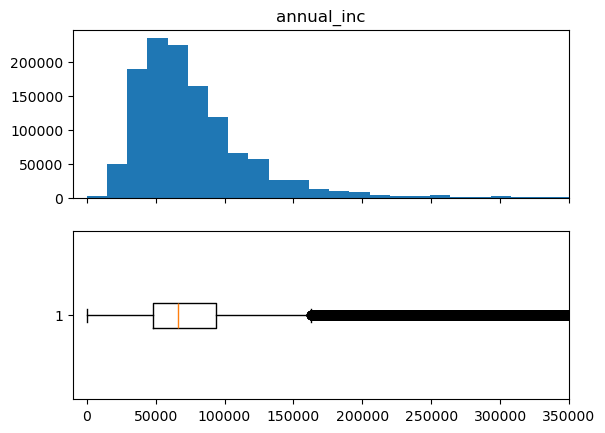

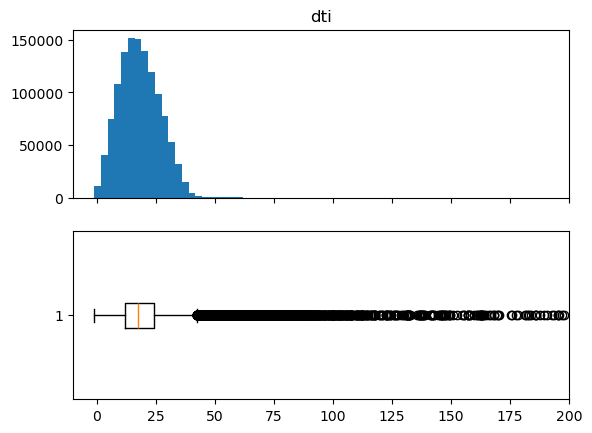

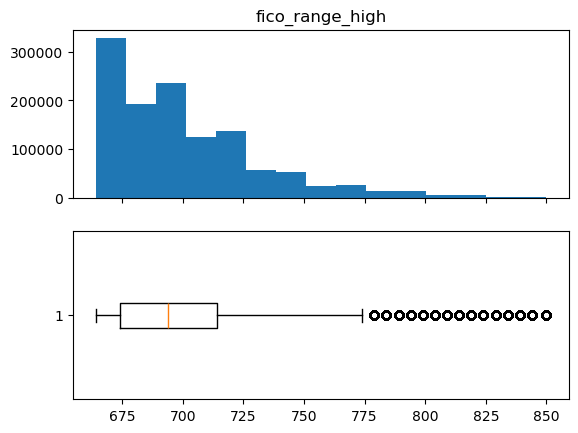

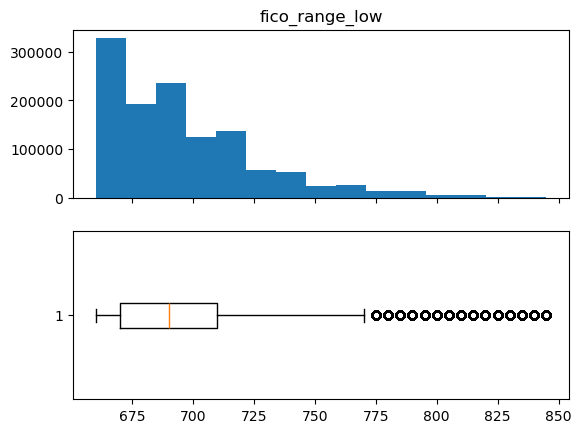

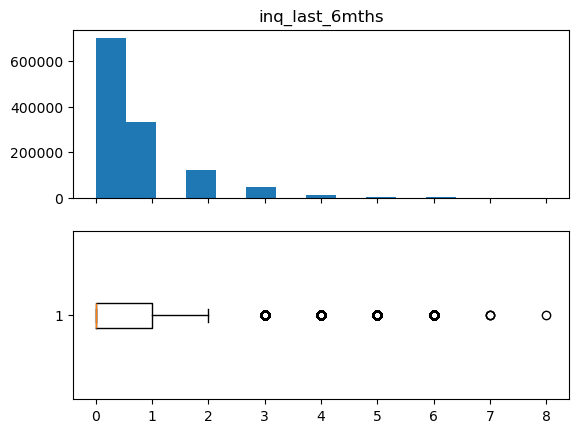

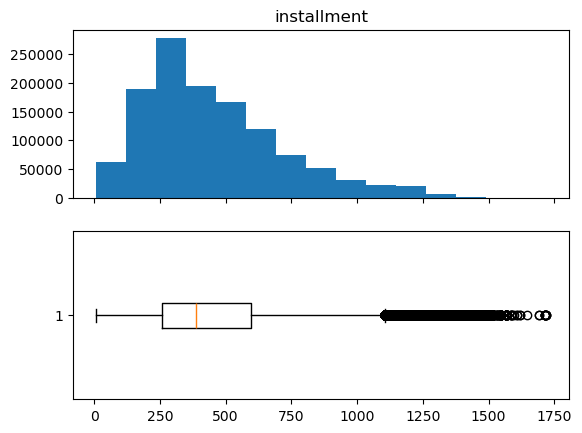

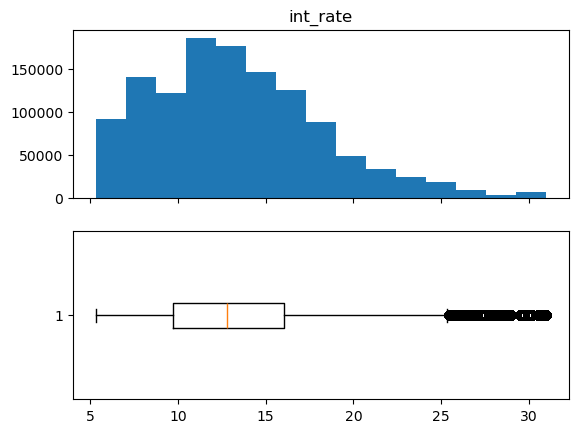

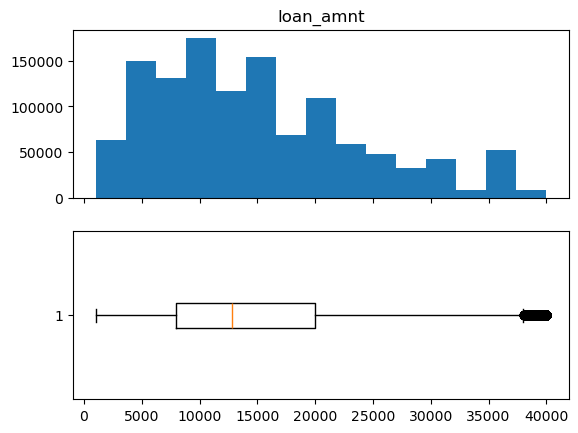

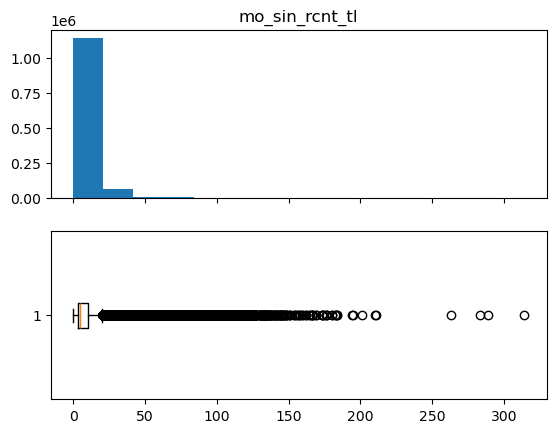

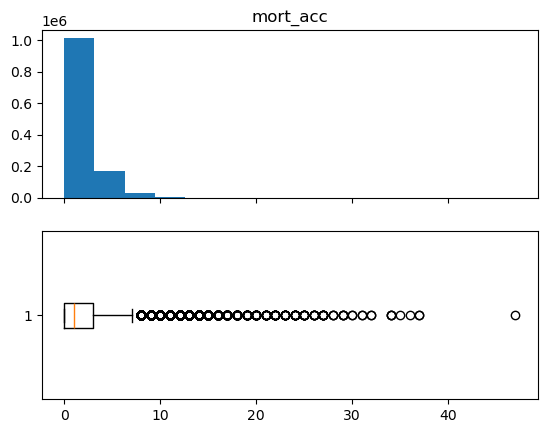

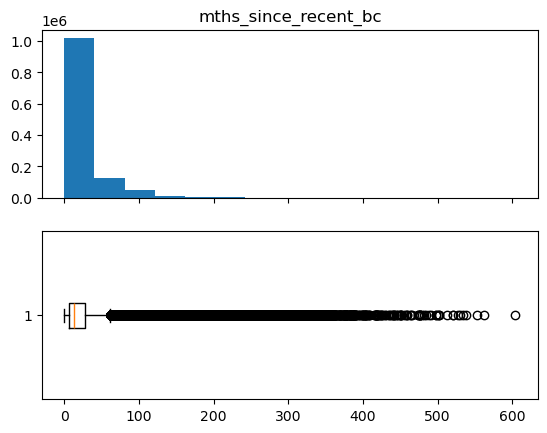

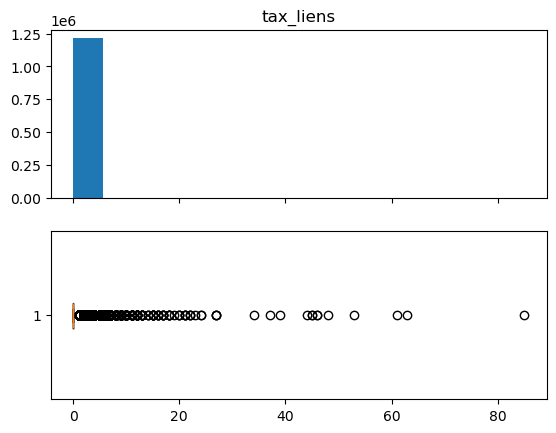

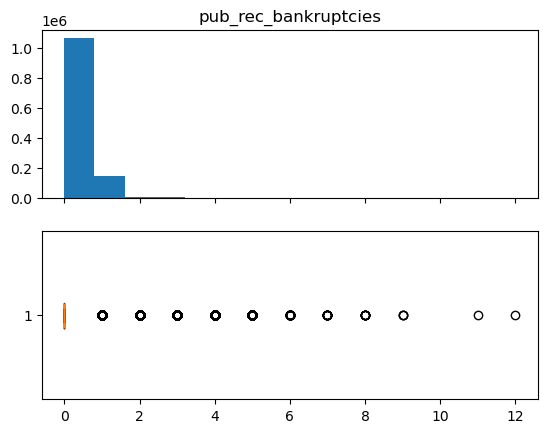

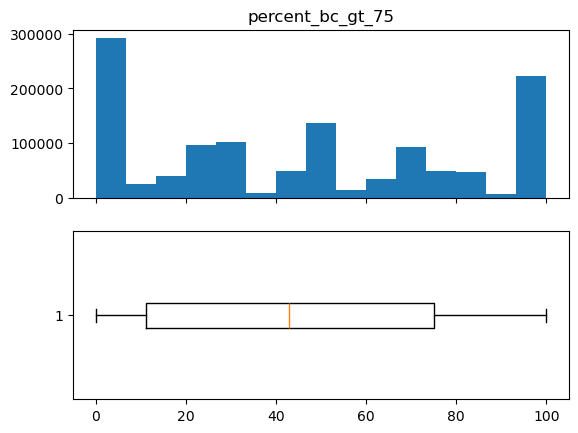

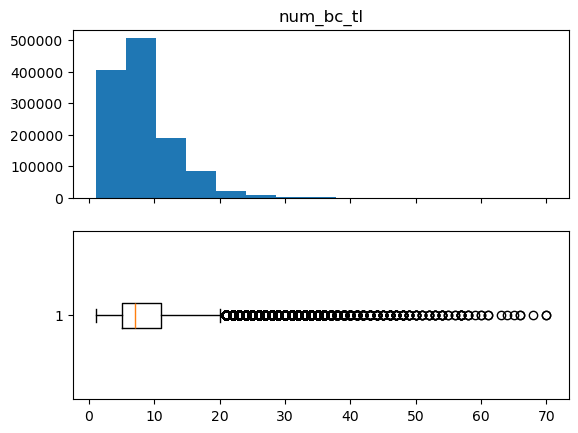

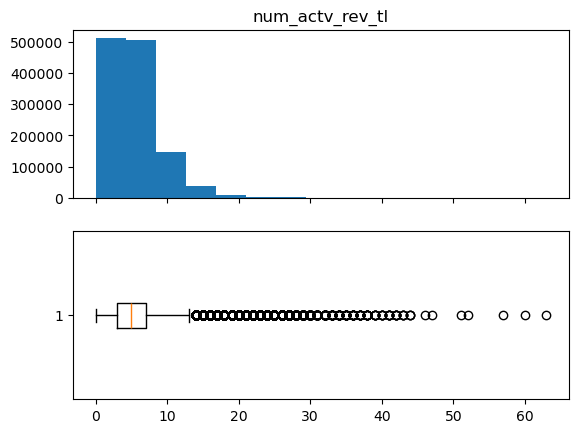

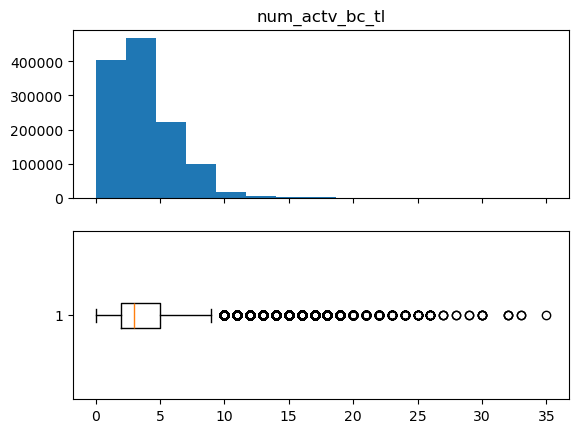

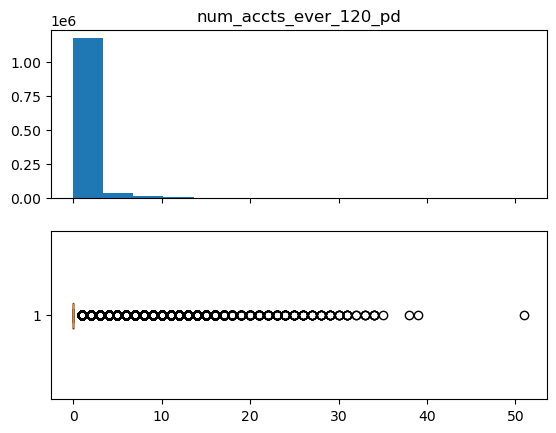

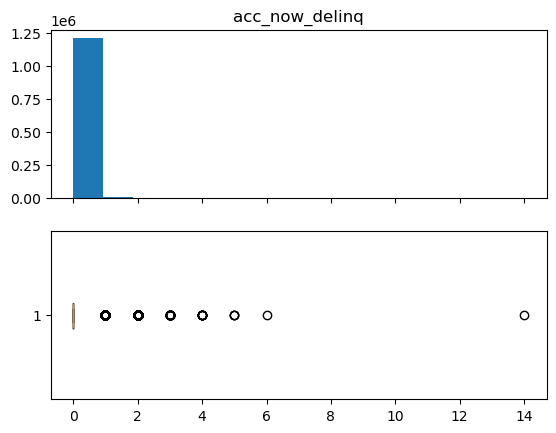

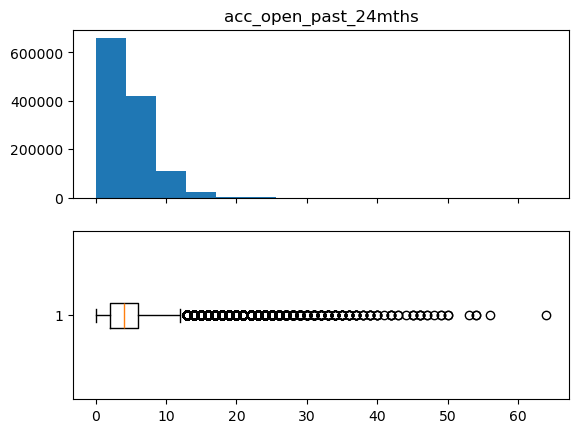

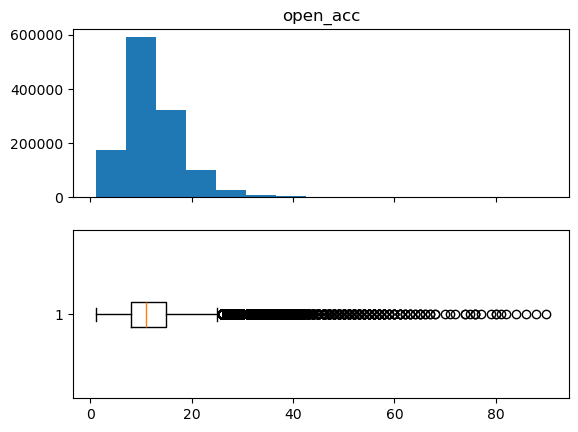

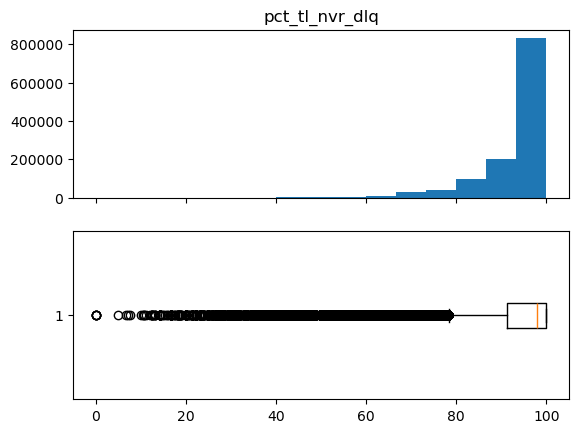

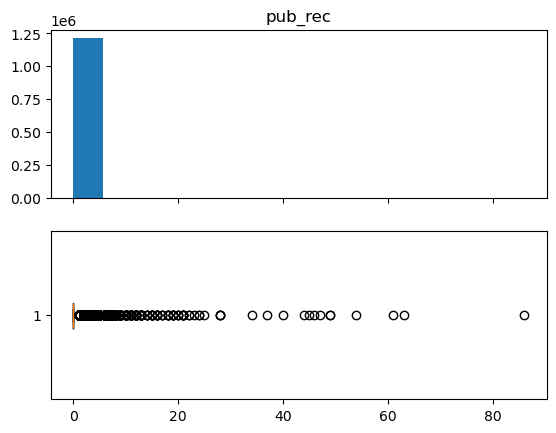

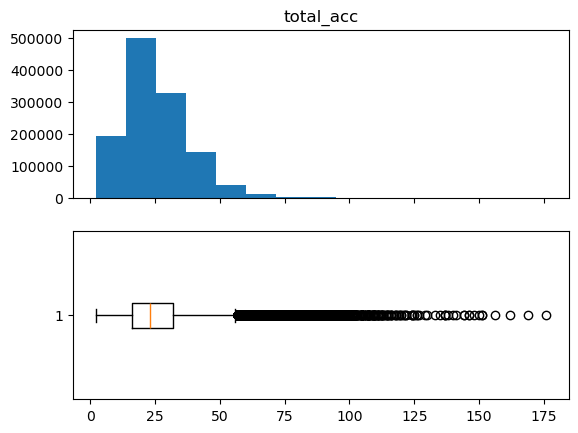

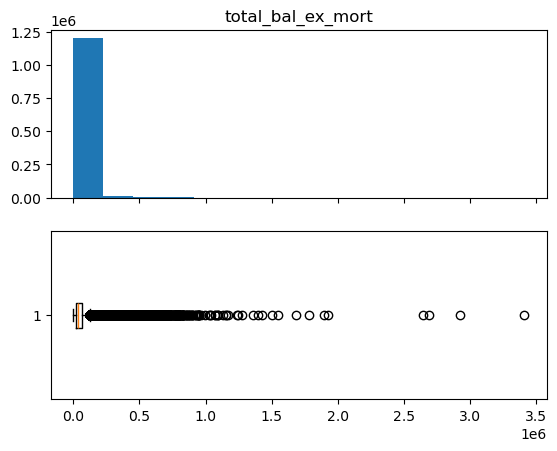

In [9]:
numeric_vars = df.columns[df.dtypes == "float64"]

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.hist(df["annual_inc"], bins = 750)
ax2.boxplot(df["annual_inc"], vert = False)
ax1.set_title("annual_inc")
ax1.set_xlim(-10000, 350000)
ax2.set_xlim(-10000, 350000)
plt.show()

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.hist(df["dti"], bins = 350)
ax2.boxplot(df["dti"], vert = False)
ax1.set_title("dti")
ax1.set_xlim(-10, 200)
ax2.set_xlim(-10, 200)
plt.show()

for var in numeric_vars:
    if var not in ["annual_inc","dti"]:
        fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
        ax1.hist(df[var], bins = 15)
        ax2.boxplot(df[var], vert = False)
        ax1.set_title(var)
        plt.show()

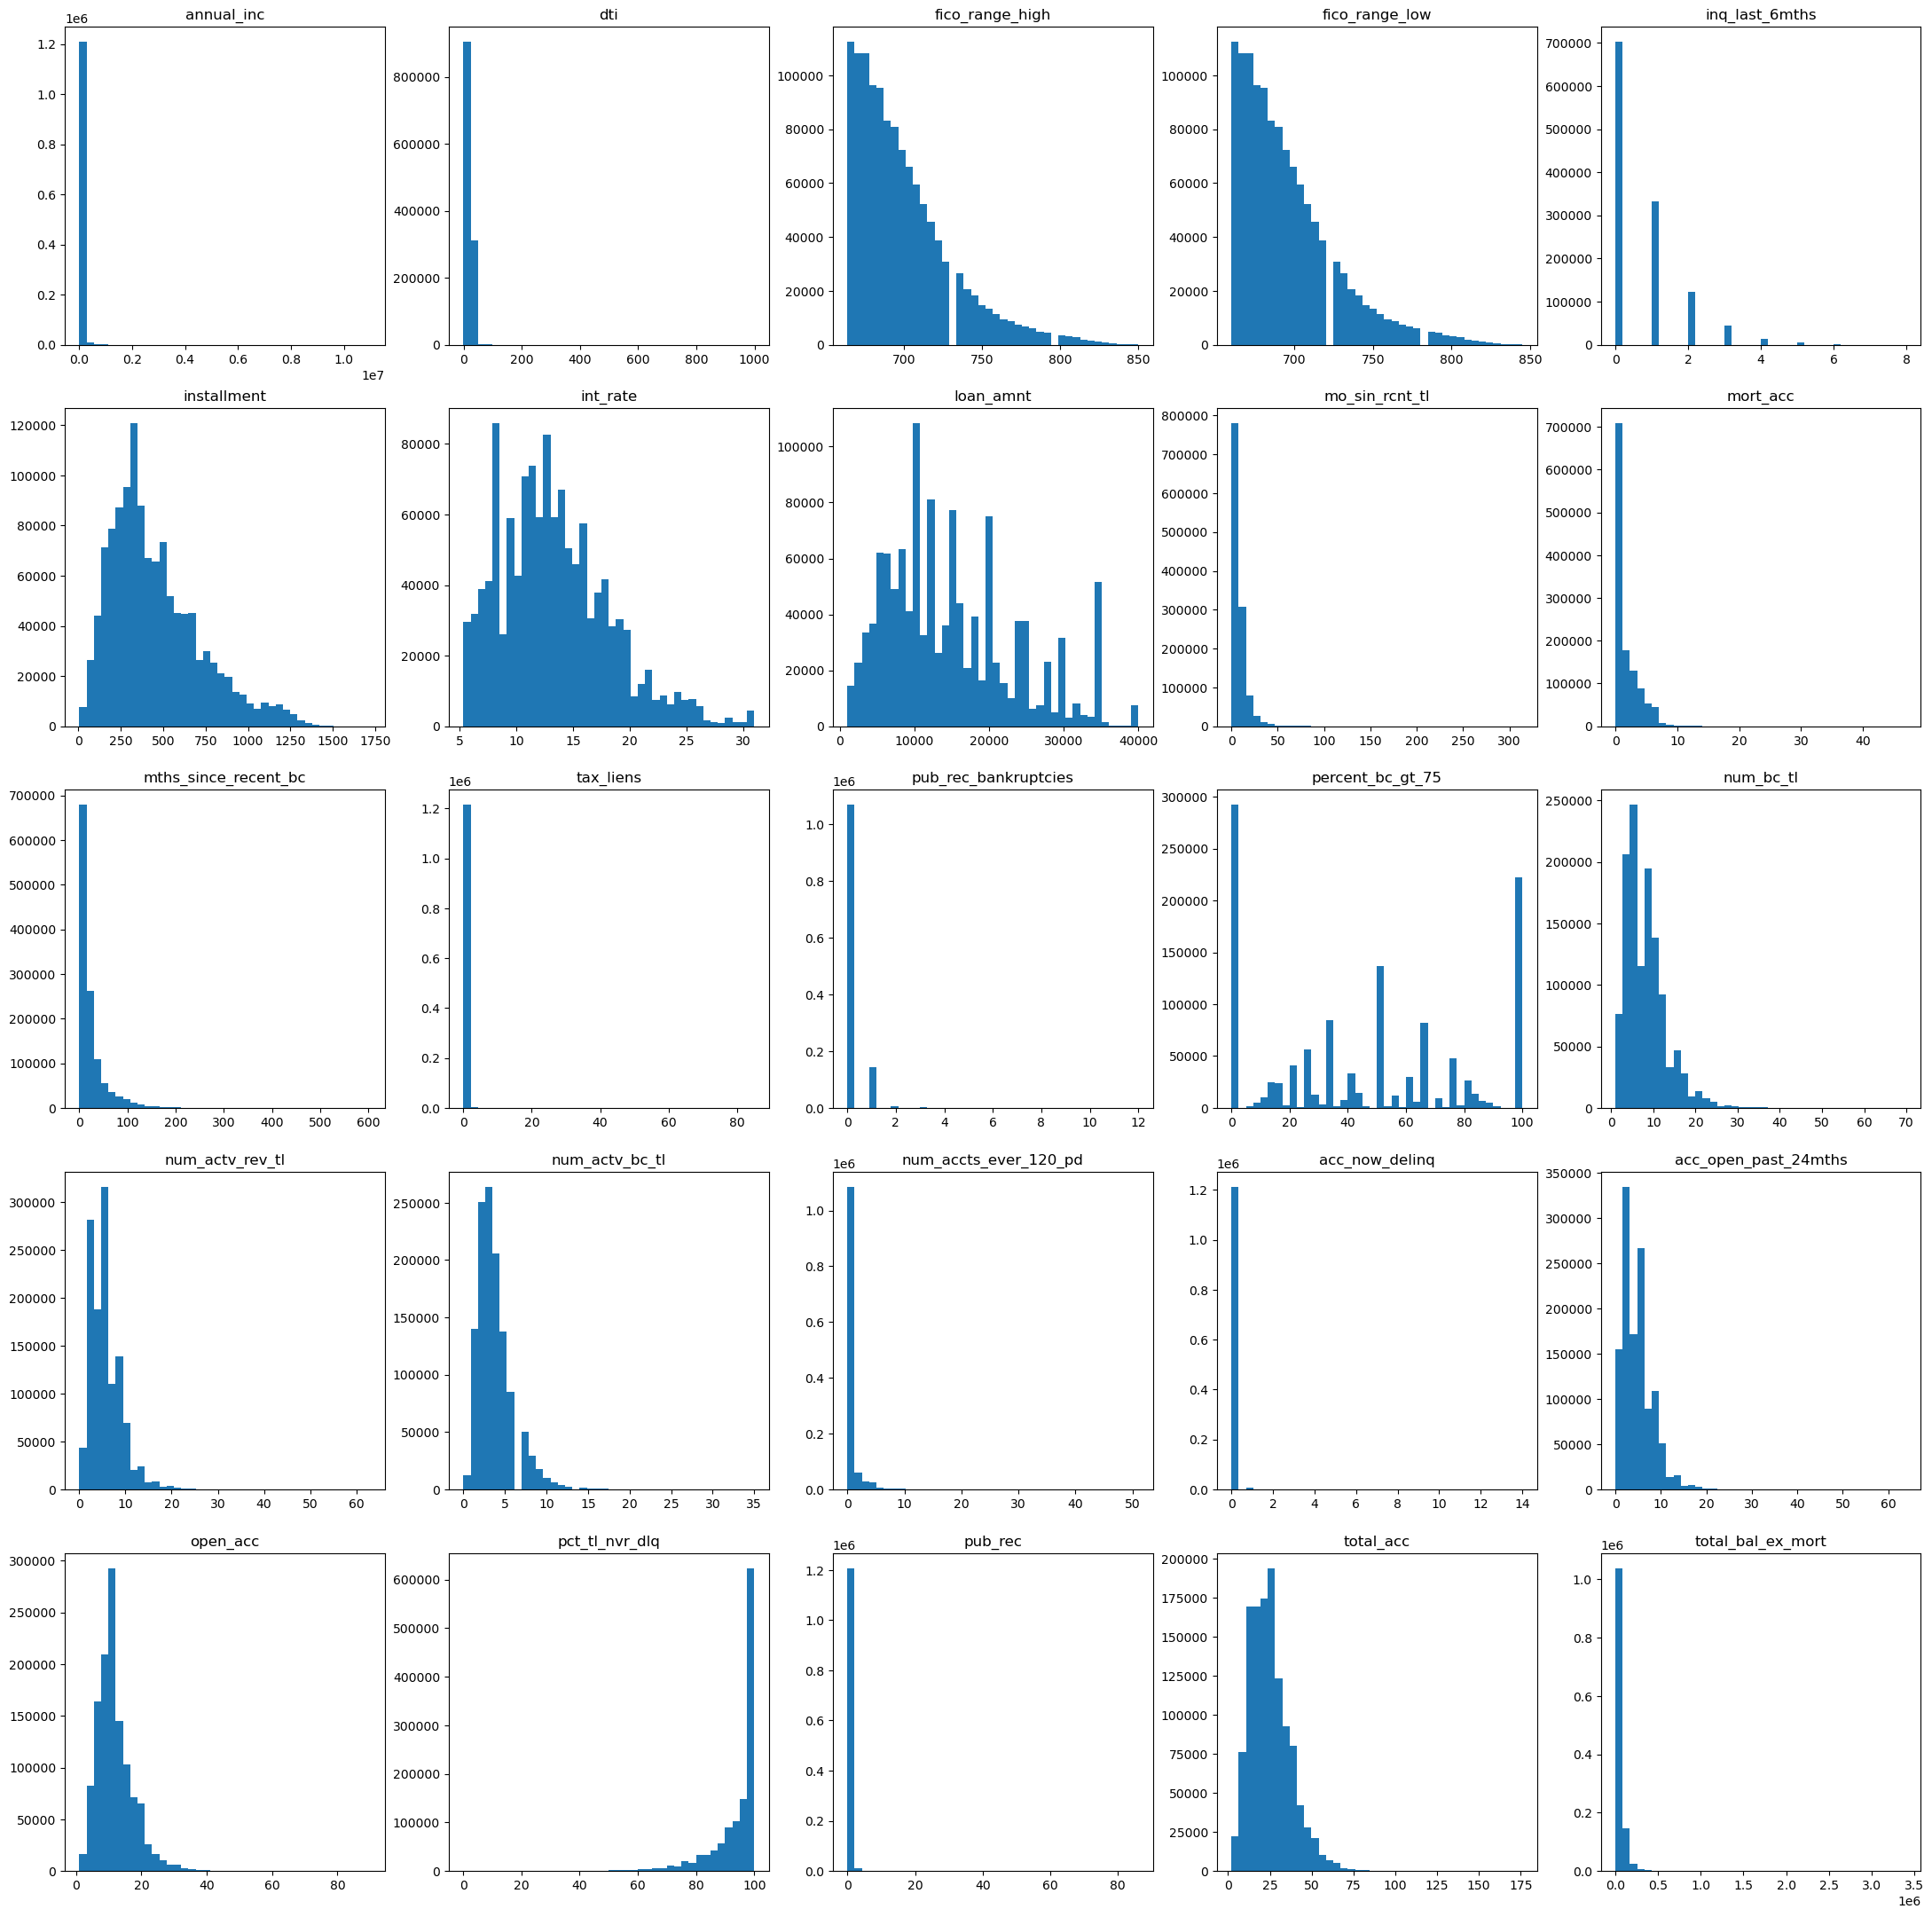

In [10]:
fig, ax = plt.subplots(nrows= 5, ncols= 5, figsize = (27,27))
ax = ax.flatten()
for i,var in enumerate(numeric_vars):
    ax[i].hist(df[var], bins = 40)
    ax[i].set_title(var)
plt.savefig("graphs/num_variables_hists.svg",facecolor = (1,1,1,0), transparent = True)
plt.show()


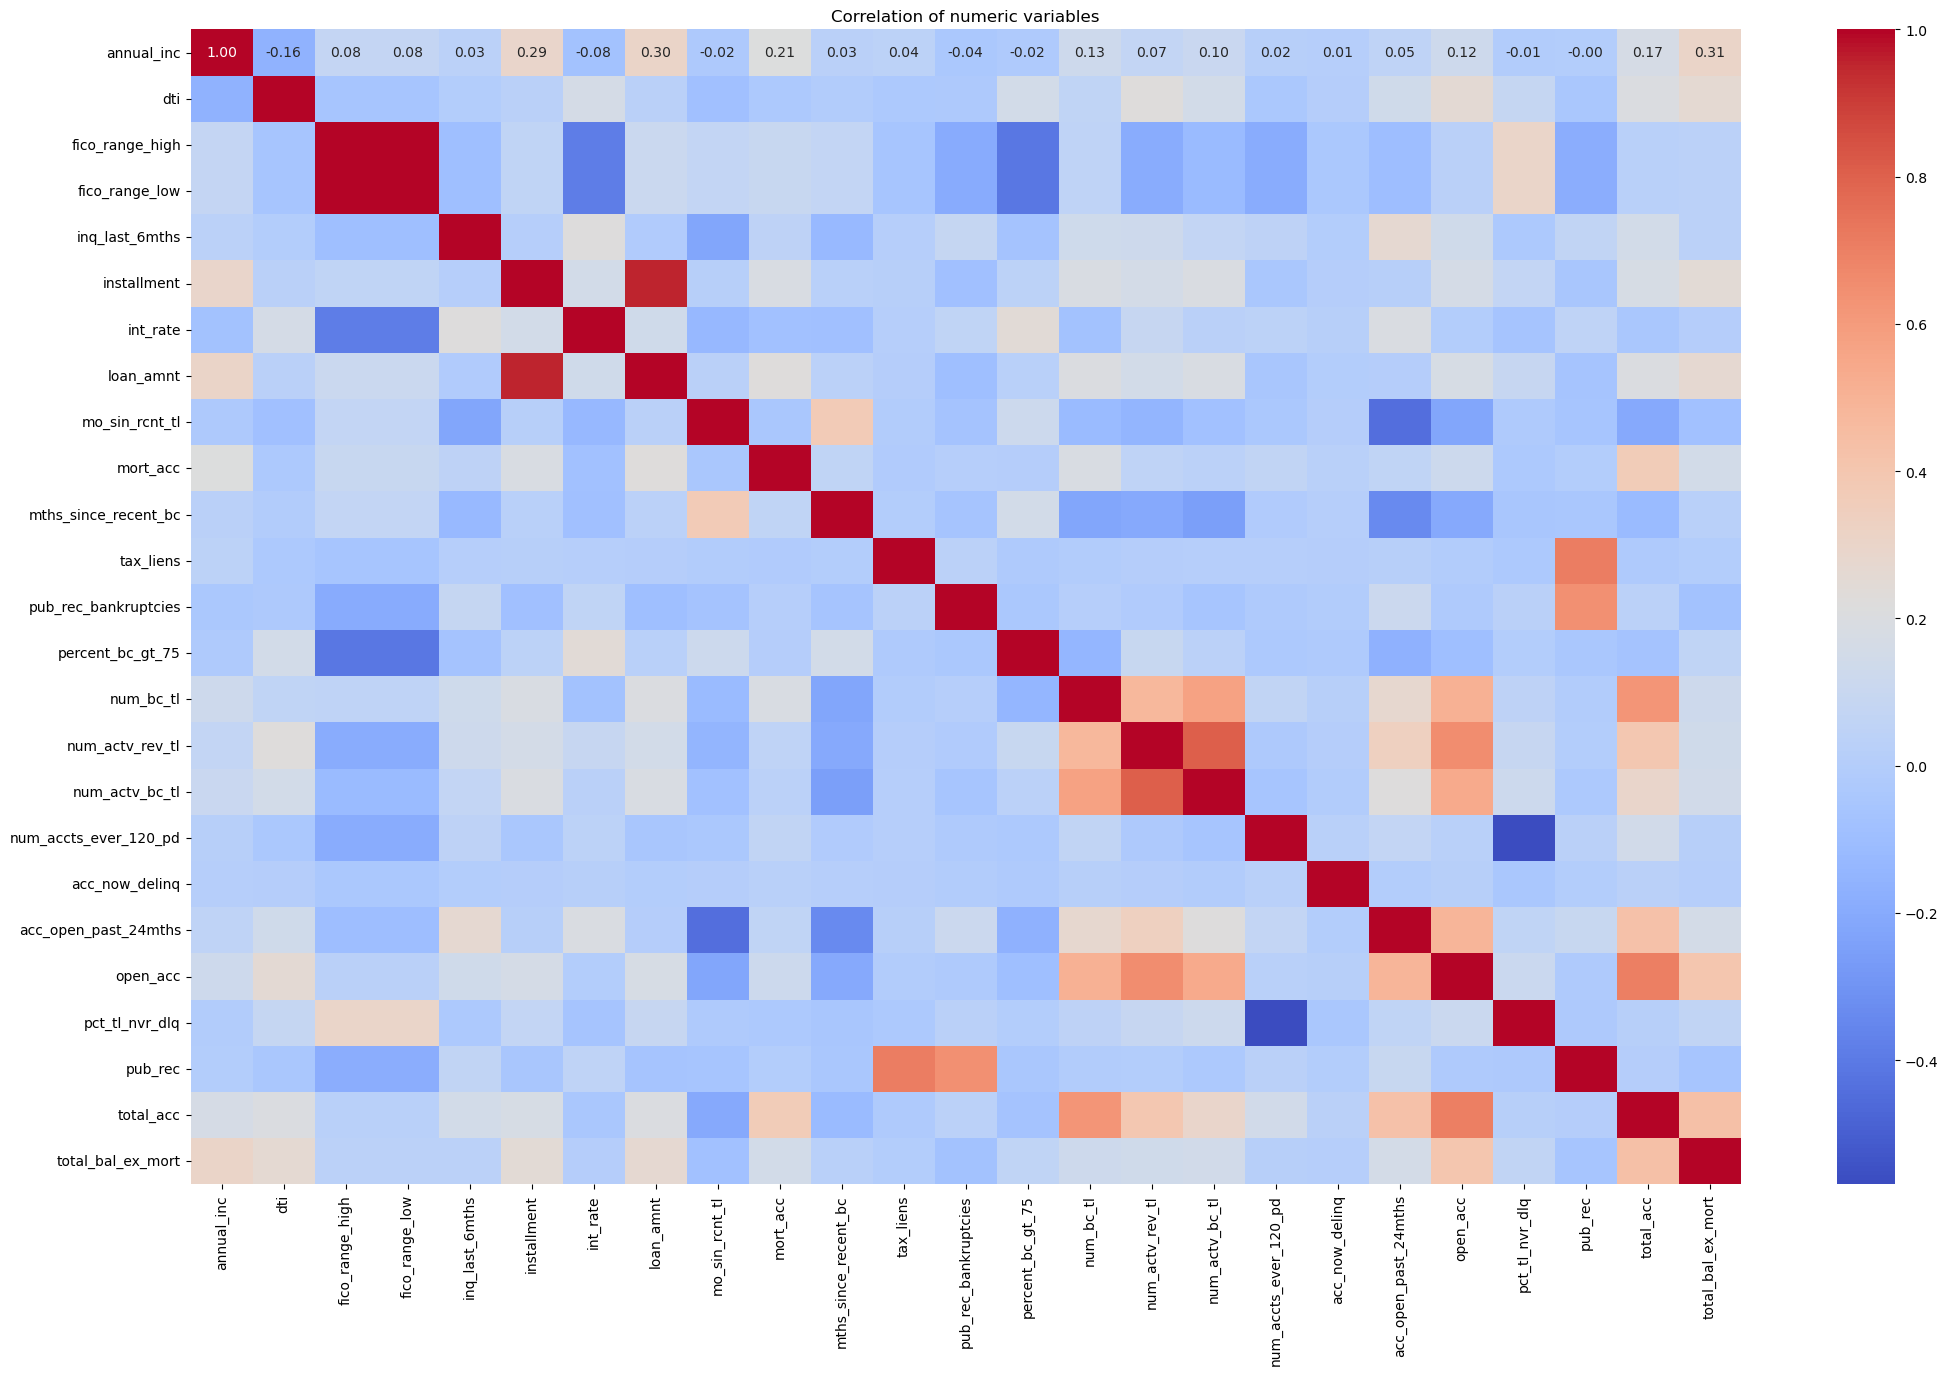

In [11]:
correlation_matrix = df[numeric_vars].corr()
plt.figure(figsize=(25,15))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation of numeric variables")
plt.show()

We can see that there are some variables that are highly correlated and just provide the same information: FICO range high and FICO range low; loan amount and installment. Regularization techinques will help dealing with this problem

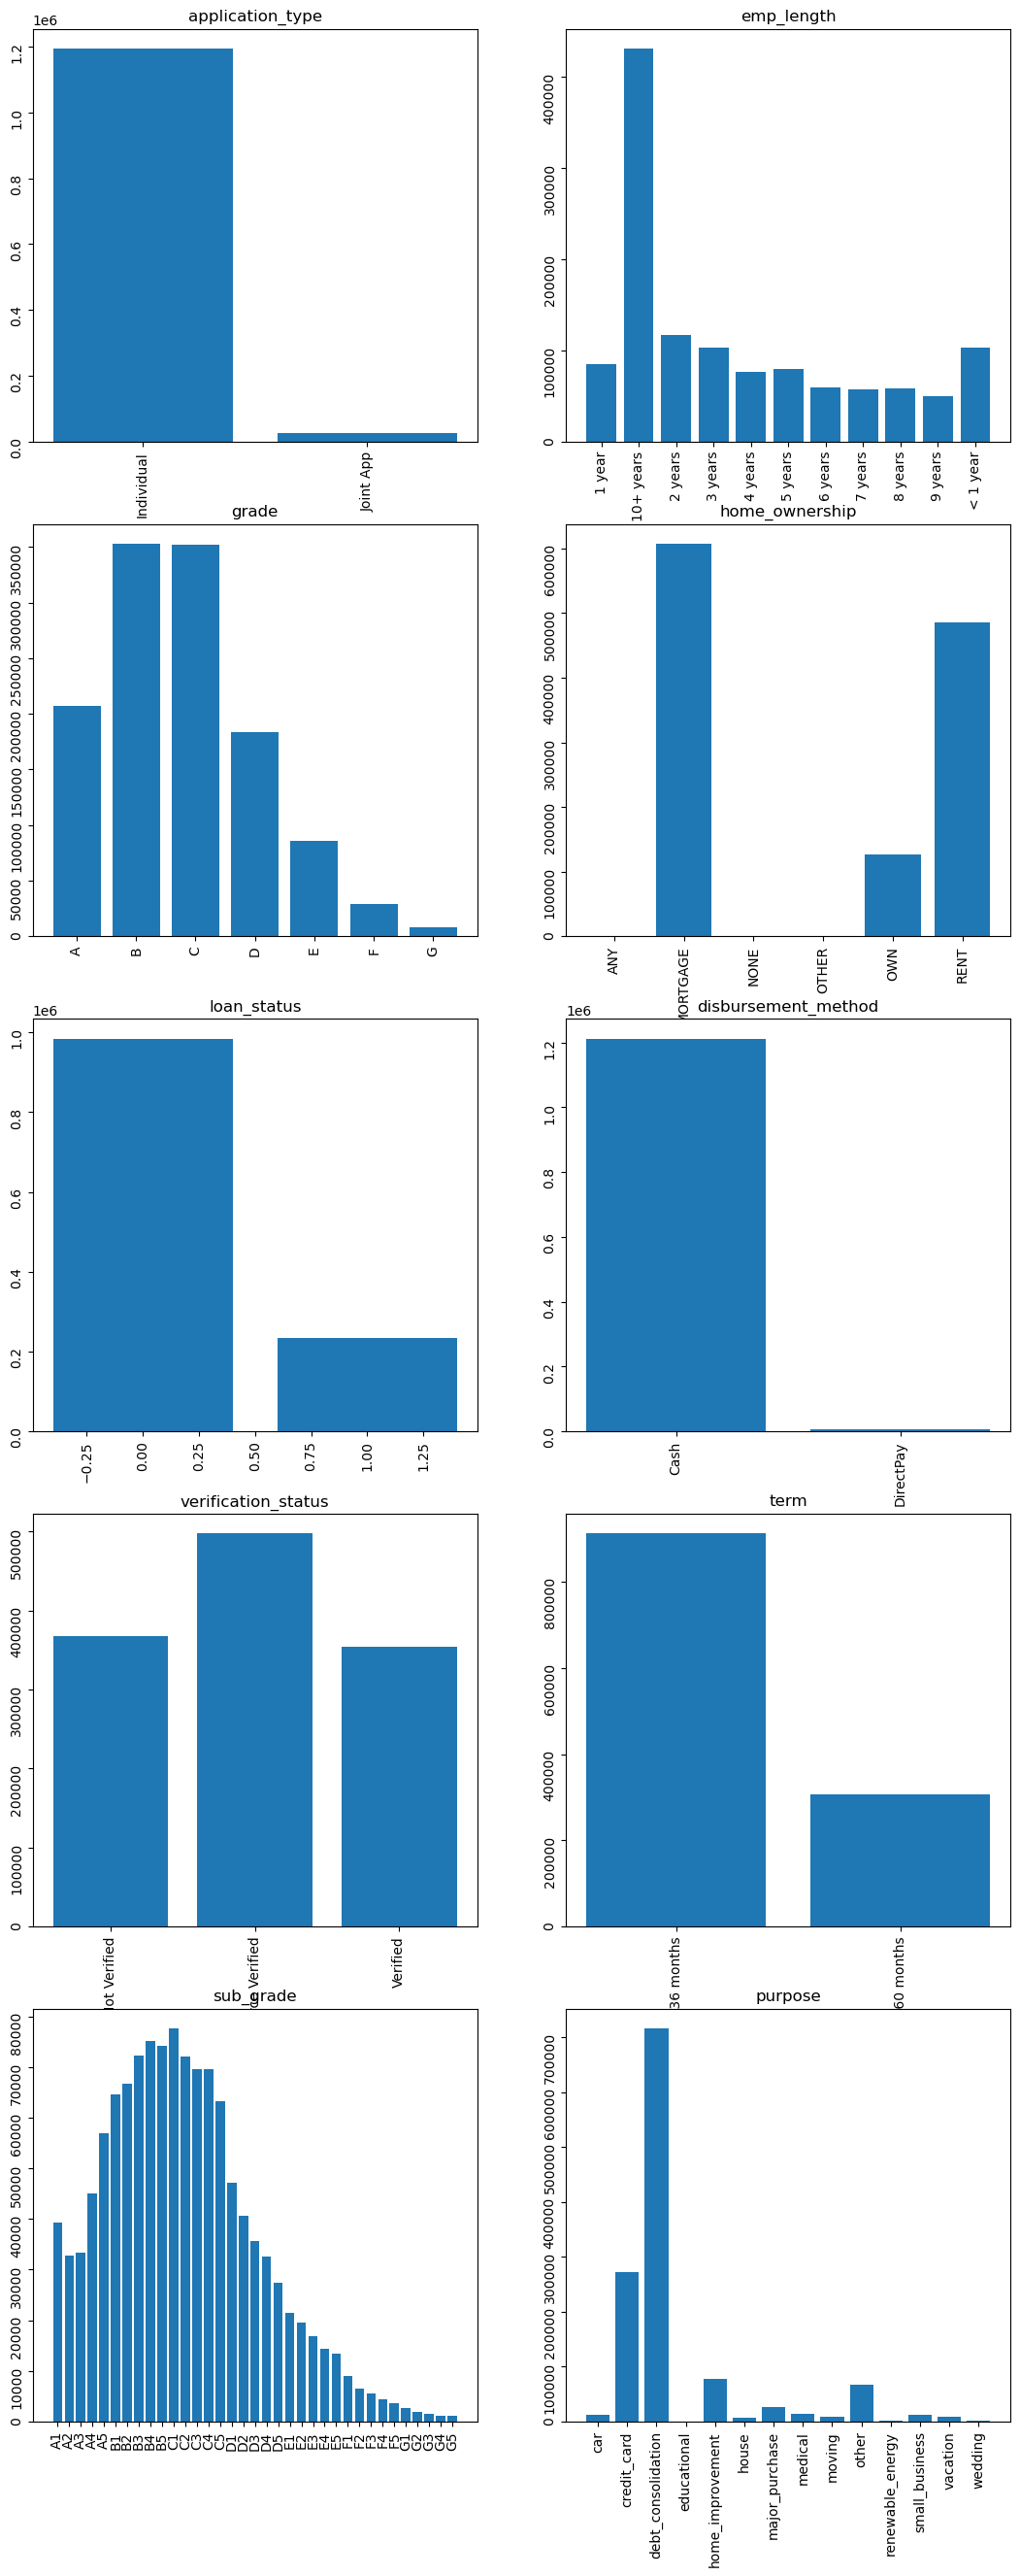

In [12]:
categorical_vars = df.columns[df.dtypes != "float64"]

fig, ax = plt.subplots(nrows= 5, ncols= 2, figsize = (13,32))
ax = ax.flatten()

i=0
for var in categorical_vars:
    if var not in ["earliest_cr_line", "issue_d"]:
        data = df[var].groupby(df[var]).count()
        ax[i].bar(x = data.index, height= data.to_numpy())
        ax[i].set_title(var)
        ax[i].tick_params(labelrotation = 90)
        i += 1 
plt.savefig("graphs/cat_vars_plots.svg",facecolor = (1,1,1,0), transparent = True)
plt.show()

Again we see that some features contain the same information: Grade and Subgrade.

## Encoding categorical Variables

We will need to transform the categorical variables to numeric ones.


In [13]:
from sklearn.preprocessing import OrdinalEncoder

term_dummies = pd.get_dummies(df.term,prefix= "term")
df = pd.concat([df, term_dummies], axis = 1)
df.drop(columns = ["term",'term_ 36 months'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop 36 months since it is the highest frequency class

#subgrade
enc = OrdinalEncoder()
sub_grade_encoded = pd.Series(enc.fit_transform(df.sub_grade.array.reshape(-1,1)).flatten())
sub_grade_encoded = sub_grade_encoded*-1 # we invert the rating: highest grade has the highest number
df.sub_grade = sub_grade_encoded

#grade
enc = OrdinalEncoder()
grade_encoded = pd.Series(enc.fit_transform(df.grade.array.reshape(-1,1)).flatten())
grade_encoded = grade_encoded*-1 # we invert the rating: highest grade has the highest number
df.grade = grade_encoded

#home ownership
# we will first collapse some classes into one: any, none and other will be grouped together
df.home_ownership[df.home_ownership == "ANY"] = "OTHER"
df.home_ownership[df.home_ownership == "NONE"] = "OTHER"

home_ownership_dummies = pd.get_dummies(df.home_ownership,prefix= "home_ownership")
df = pd.concat([df, home_ownership_dummies], axis = 1)
df.drop(columns = ["home_ownership",'home_ownership_MORTGAGE'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop MORTGAGE since it is the highest frequency class

# verification status
verification_status_dummies = pd.get_dummies(df.verification_status,prefix= "verification_status")
df = pd.concat([df, verification_status_dummies], axis = 1)
df.drop(columns = ["verification_status",'verification_status_Source Verified'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop Source Verified since it is the highest frequency class

#purpose
# first we group educational with other because there is only one instance of it
df.purpose[df.purpose == "educational"] = "other"
purpose_dummies = pd.get_dummies(df.purpose,prefix= "purpose")
df = pd.concat([df, purpose_dummies], axis = 1)
df.drop(columns = ["purpose",'purpose_debt_consolidation'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop educational because there is only one value

#application_type
application_type_dummies = pd.get_dummies(df.application_type,prefix= "application_type")
df = pd.concat([df, application_type_dummies], axis = 1)
df.drop(columns = ["application_type",'application_type_Individual'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop application_type since it is the highest frequency class

# disbursement_method
disbursement_method_dummies = pd.get_dummies(df.disbursement_method,prefix= "disbursement_method")
df = pd.concat([df, disbursement_method_dummies], axis = 1)
df.drop(columns = ["disbursement_method",'disbursement_method_Cash'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop Cash since it is the highest frequency class

#emp_length
emp_length_map = {
    "1 year": 1,
    "10+ years":10,
    "2 years":2,
    "3 years":3,
    "4 years":4,
    "5 years":5,
    "6 years":6,
    "7 years":7,
    "8 years":8,
    "9 years":9,
    "< 1 year" : 0
}

df.emp_length = df.emp_length.map(emp_length_map)



C:\Users\giuse\AppData\Local\Temp\ipykernel_18540\934061891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.home_ownership[df.home_ownership == "ANY"] = "OTHER"
C:\Users\giuse\AppData\Local\Temp\ipykernel_18540\934061891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.home_ownership[df.home_ownership == "NONE"] = "OTHER"
C:\Users\giuse\AppData\Local\Temp\ipykernel_18540\934061891.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

We also have the variables Issue date and Earliest credit line that are a timestamp. We will encode it with an integer number, setting 0 for the earliest date and the highest number for the latest date

In [14]:
#earliest_credit_line
enc = OrdinalEncoder()
earliest_cr_line_encoded = pd.Series(enc.fit_transform(pd.to_datetime(df.earliest_cr_line, format = "%b-%Y").array.reshape(-1,1)).flatten())
df.earliest_cr_line = earliest_cr_line_encoded

#issue_date
enc = OrdinalEncoder()
issue_d_encoded = pd.Series(enc.fit_transform(pd.to_datetime(df.issue_d, format = "%b-%Y").array.reshape(-1,1)).flatten())
df.issue_d = issue_d_encoded

In [15]:
df.isna().sum().sum()

0

We now plot the variables' distributions according to class of target variable.

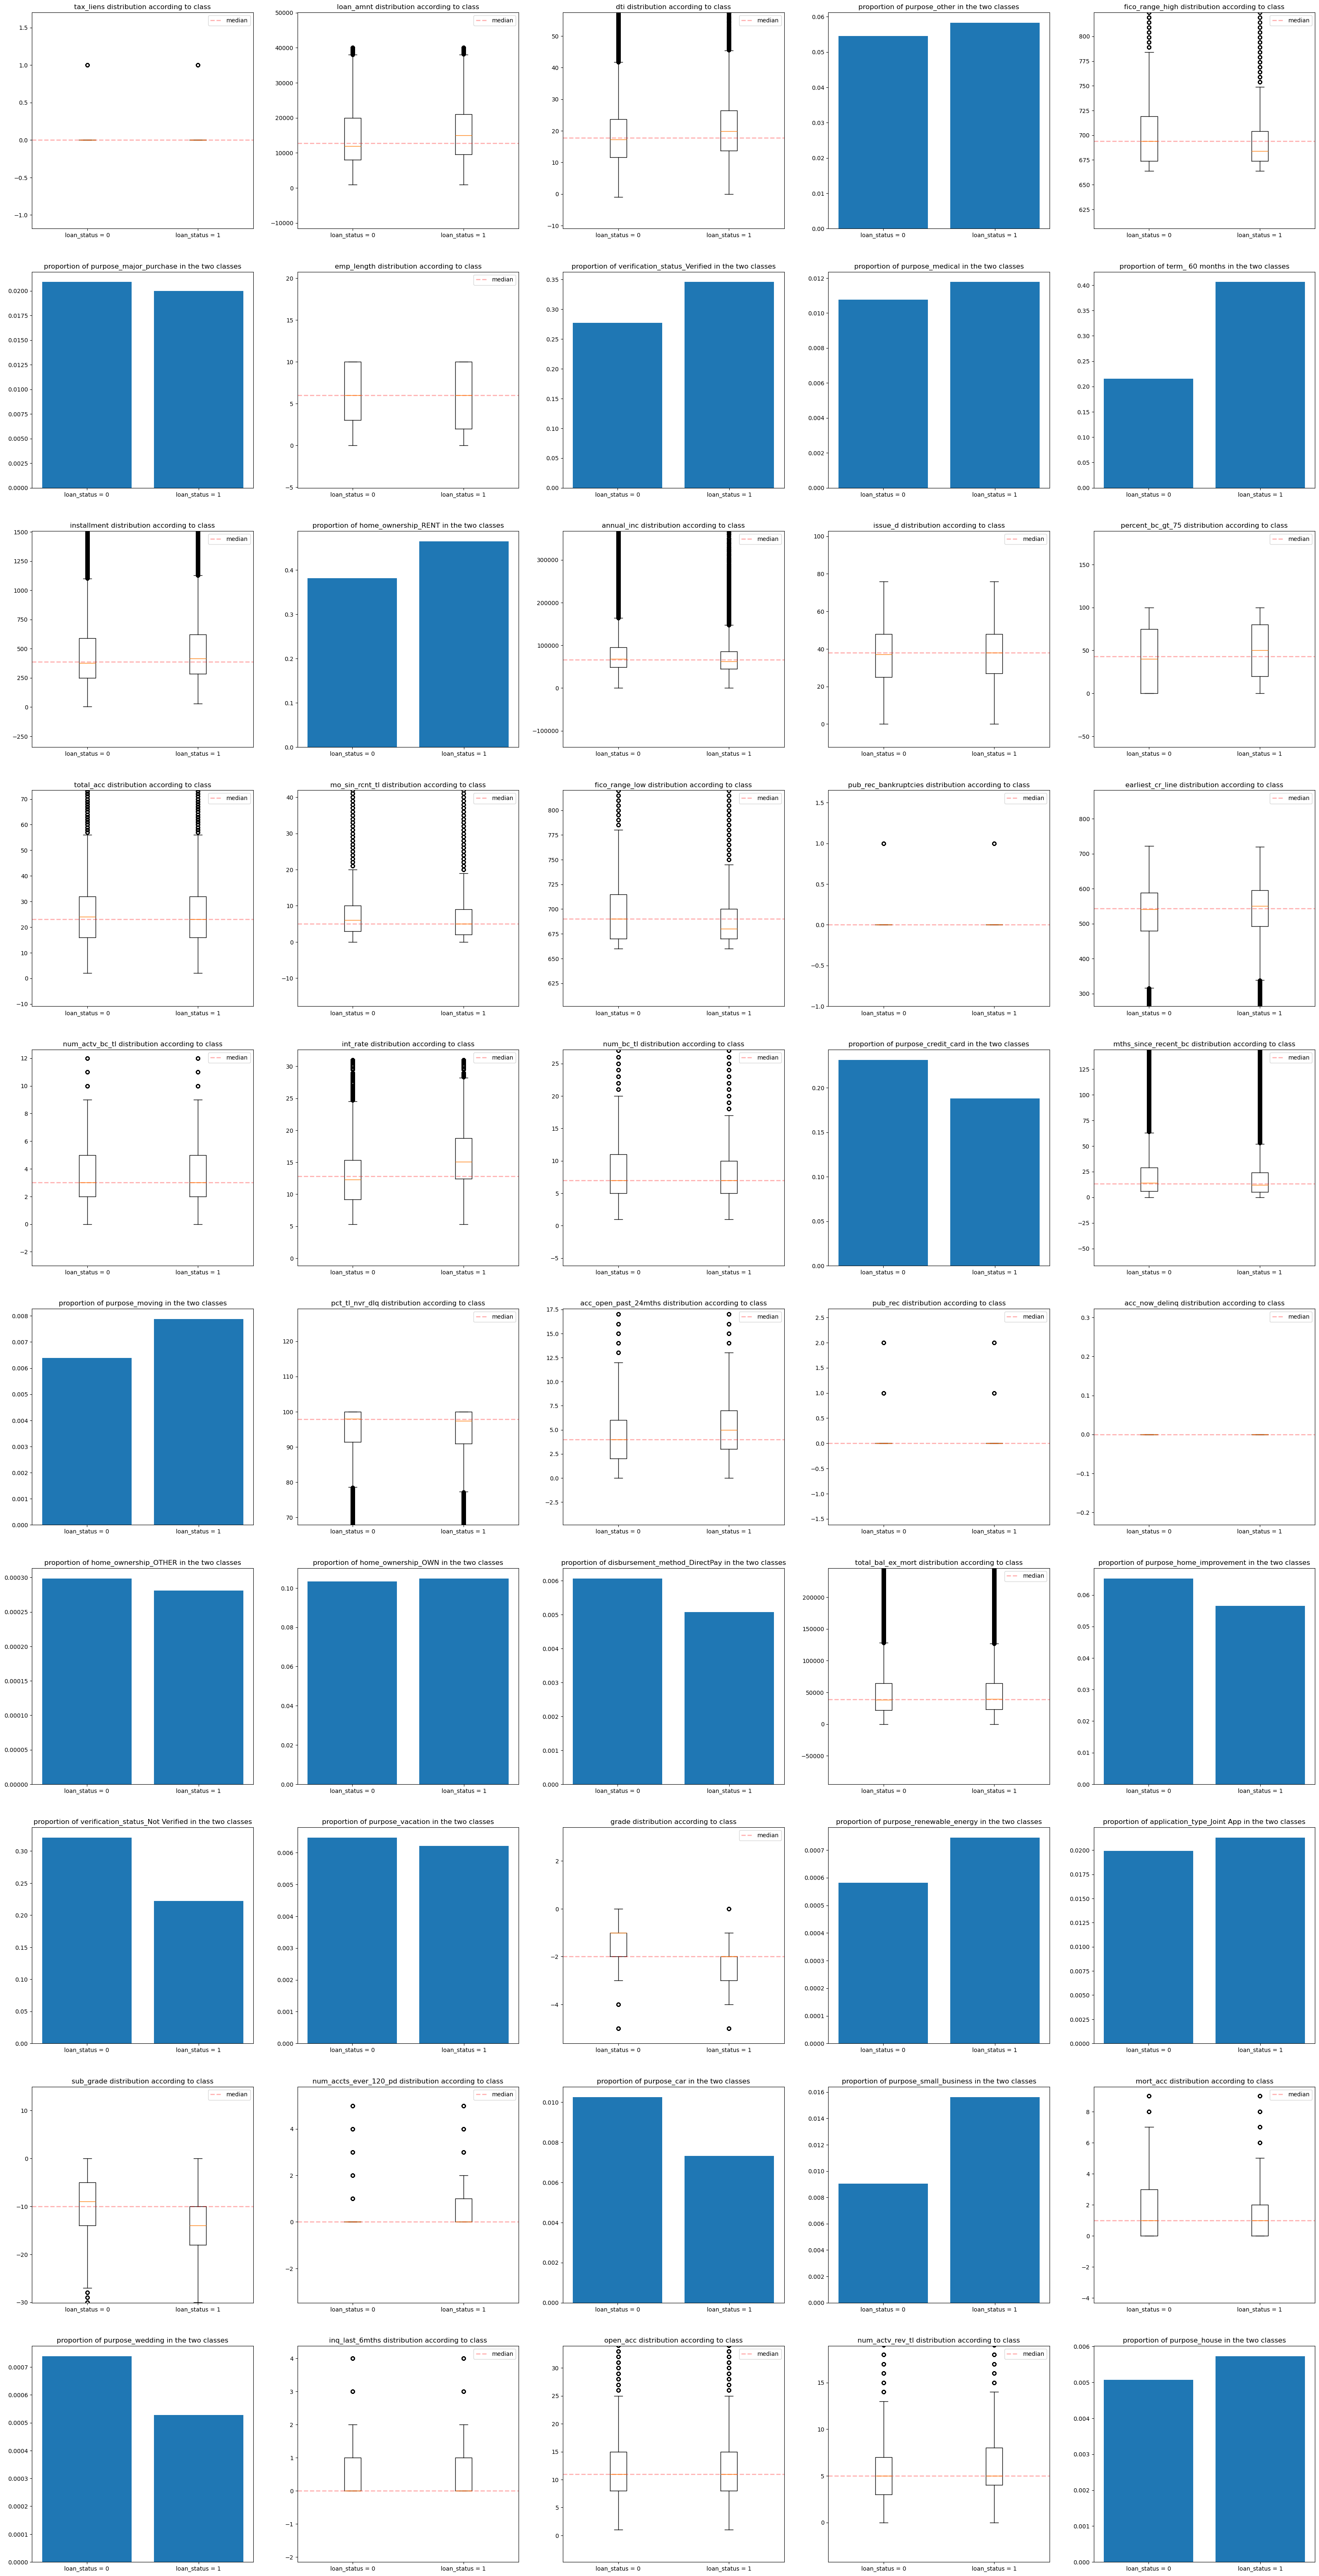

In [16]:
fig, ax = plt.subplots(nrows= 10, ncols= 5, figsize = (40,80))
ax = ax.flatten()

n_loan_status_0 = (df[df.loan_status == 0]).shape[0]
n_loan_status_1 = (df[df.loan_status == 1]).shape[0]
for i,var_name in enumerate(set(df.columns)-set(["loan_status"])):
    if df[var_name].value_counts().size == 2:
        ax[i].bar(x = ("loan_status = 0","loan_status = 1"), height=(df[df.loan_status == 0][var_name].sum()/n_loan_status_0,df[df.loan_status == 1][var_name].sum()/n_loan_status_1))
        ax[i].set_title("proportion of "+var_name +" in the two classes")
    else:
        ax[i].boxplot([df[var_name][df.loan_status == 0],df[var_name][df.loan_status == 1]])
        ax[i].axhline(y=df[var_name].median(), color='r', alpha =0.3, linestyle='--', linewidth=2,label="median")
        ax[i].set_ylim((df[var_name].mean() - 3*df[var_name].std(), df[var_name].mean() + 4*df[var_name].std()))
        ax[i].set_title(var_name + " distribution according to class")
        ax[i].set_xticklabels(("loan_status = 0","loan_status = 1"))
        ax[i].legend()


## Splitting into training, validation, testing


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["loan_status"]), df.loan_status, test_size=0.3, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=0)

# undersampling of majority class in train dataset
status_1_idx = ((y_train[y_train == 1]).index).array
status_0_idx = ((y_train[y_train == 0]).index).array
np.random.seed(0)
sampled_idx = np.random.choice(status_0_idx, size = status_1_idx.size, replace = False)
sampled_idx = np.concatenate((sampled_idx, status_1_idx))
print("number of rows in train set before undersampling",X_train.index.size)
print("number of rows in train set after undersampling",sampled_idx.size)

y_train = y_train.loc[sampled_idx]
X_train = X_train.loc[sampled_idx]

number of rows in train set before undersampling 512137
number of rows in train set after undersampling 197440


We standardize the variables

In [18]:
train_means = X_train.mean()
train_stds = X_train.std()
X_train= (X_train-train_means)/train_stds
X_val = (X_val-train_means)/train_stds
X_test = (X_test-train_means)/train_stds

In [19]:
# X_train.to_csv("C:/Users/giuse/DatiR/lending_club/X_train.csv",index=False)
# y_train.to_csv("C:/Users/giuse/DatiR/lending_club/y_train.csv",index=False)
# X_val.to_csv("C:/Users/giuse/DatiR/lending_club/X_val.csv",index=False)
# y_val.to_csv("C:/Users/giuse/DatiR/lending_club/y_val.csv",index=False)
# X_test.to_csv("C:/Users/giuse/DatiR/lending_club/X_test.csv",index=False)
# y_test.to_csv("C:/Users/giuse/DatiR/lending_club/y_test.csv",index=False)

## Linear models


### Logistic regression with no penalty

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix

In [20]:
logreg_model = LogisticRegression(penalty = None,max_iter=1000)
# we explicitly set the penalty to none so there is no regularization
logreg_model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, penalty=None)

In [21]:
logReg_yhat_val = logreg_model.predict(X_val)
logreg_phat_val = logreg_model.predict_proba(X_val)[:,1]

print("L1 norm of coefficients: ", np.abs(logreg_model.coef_).sum())
print("L2 norm of coefficients: ", (logreg_model.coef_**2).sum())
print("accuracy", accuracy_score(y_val,logReg_yhat_val))
print(classification_report(y_val,logReg_yhat_val))
logreg_cm = pd.DataFrame(confusion_matrix(y_val, logReg_yhat_val))
logreg_cm.index.name="actual"
logreg_cm.columns.name="predicted"
print(logreg_cm)

print("Coefficients of unregularized model")
# Coeffs of unregularized model
logreg_coeffs = (pd.Series(logreg_model.coef_[0], index = logreg_model.feature_names_in_)).sort_values()
logreg_coeffs

L1 norm of coefficients:  3.148642485537606
L2 norm of coefficients:  0.8666789120409131
accuracy 0.6564936472324896
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181483  94320
1           22962  42661
Coefficients of unregularized model


sub_grade                          -0.728776
int_rate                           -0.327940
mort_acc                           -0.097483
annual_inc                         -0.087941
fico_range_low                     -0.079104
fico_range_high                    -0.078461
total_acc                          -0.077559
total_bal_ex_mort                  -0.059559
verification_status_Not Verified   -0.049306
mths_since_recent_bc               -0.046357
disbursement_method_DirectPay      -0.032651
application_type_Joint App         -0.031895
emp_length                         -0.027275
purpose_credit_card                -0.024223
num_bc_tl                          -0.017835
pub_rec_bankruptcies               -0.014494
mo_sin_rcnt_tl                     -0.012449
verification_status_Verified       -0.012124
purpose_car                        -0.010574
purpose_wedding                    -0.009802
pct_tl_nvr_dlq                     -0.005323
earliest_cr_line                   -0.004684
home_owner

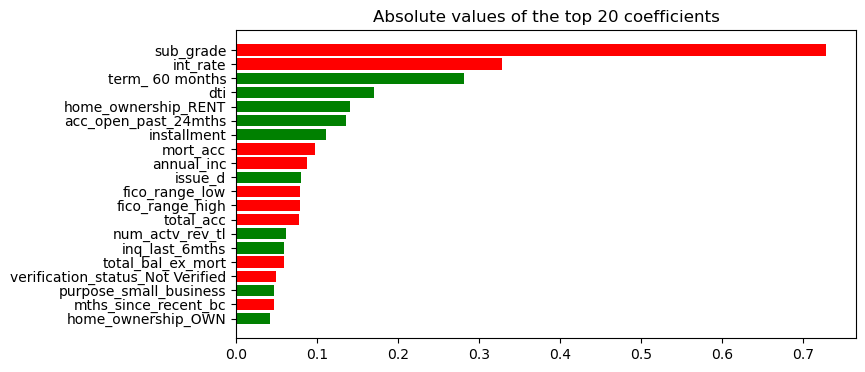

In [22]:
sorted_coeffs = logreg_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs.iloc[-20:]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of the top 20 coefficients")
plt.savefig("graphs/logreg_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

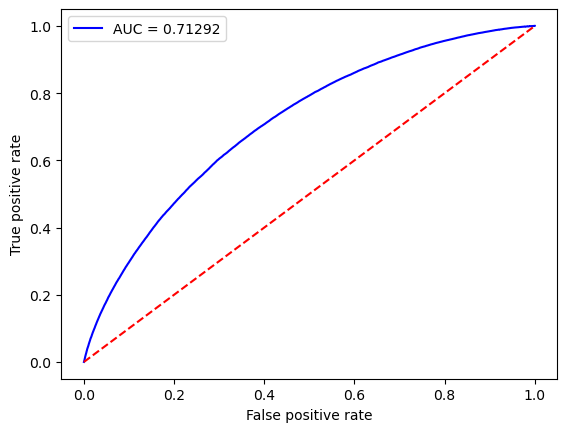

In [23]:
#Roc Curve
logReg_fpr, logReg_tpr, logReg_thresholds = roc_curve(y_val, logreg_phat_val)
logreg_auc_val = roc_auc_score(y_val, logreg_phat_val)
plt.plot(logReg_fpr,logReg_tpr, "b", label = "AUC = %0.5f"%logreg_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

### LASSO

In [24]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.
# c_values = np.exp(np.arange(10,-1,-0.25))**-1

#parameter cv= number of folds to use in cross validation

lassocv_model = LogisticRegressionCV(penalty="l1", solver="saga", Cs = 40, cv = 5, max_iter = 3500, n_jobs = -1,verbose = 0)
lassocv_model.fit(X_train,y_train)

LogisticRegressionCV(Cs=40, cv=5, max_iter=3500, n_jobs=-1, penalty='l1',
                     solver='saga')

In [25]:
lassocv_yhat_val = lassocv_model.predict(X_val)
lassocv_phat_val = lassocv_model.predict_proba(X_val)[:,1]

print("num of coefs that have been shrunk to 0: ", (lassocv_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(lassocv_model.coef_).sum())
print("L2 norm of coefficients: ", (lassocv_model.coef_**2).sum())
print("accuracy", accuracy_score(y_val,lassocv_yhat_val))
print(classification_report(y_val,lassocv_yhat_val))
lassocv_cm = pd.DataFrame(confusion_matrix(y_val, lassocv_yhat_val))
lassocv_cm.index.name="actual"
lassocv_cm.columns.name="predicted"
print(lassocv_cm)
print("Coefficients of LASSO model")
lassocv_coeffs=(pd.Series(lassocv_model.coef_[0], index = lassocv_model.feature_names_in_)).sort_values()
lassocv_coeffs

num of coefs that have been shrunk to 0:  2
L1 norm of coefficients:  2.997828944441486
L2 norm of coefficients:  0.7680260389413405
accuracy 0.6566020162494948
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181556  94247
1           22998  42625
Coefficients of LASSO model


sub_grade                          -0.684846
int_rate                           -0.287759
mort_acc                           -0.097702
annual_inc                         -0.084779
fico_range_low                     -0.080566
fico_range_high                    -0.076764
total_acc                          -0.075617
total_bal_ex_mort                  -0.058163
verification_status_Not Verified   -0.048976
mths_since_recent_bc               -0.045691
disbursement_method_DirectPay      -0.031939
application_type_Joint App         -0.031315
emp_length                         -0.026280
purpose_credit_card                -0.023823
num_bc_tl                          -0.016184
mo_sin_rcnt_tl                     -0.011986
verification_status_Verified       -0.011133
purpose_car                        -0.010003
pub_rec_bankruptcies               -0.009922
purpose_wedding                    -0.009212
pct_tl_nvr_dlq                     -0.004989
earliest_cr_line                   -0.002870
home_owner

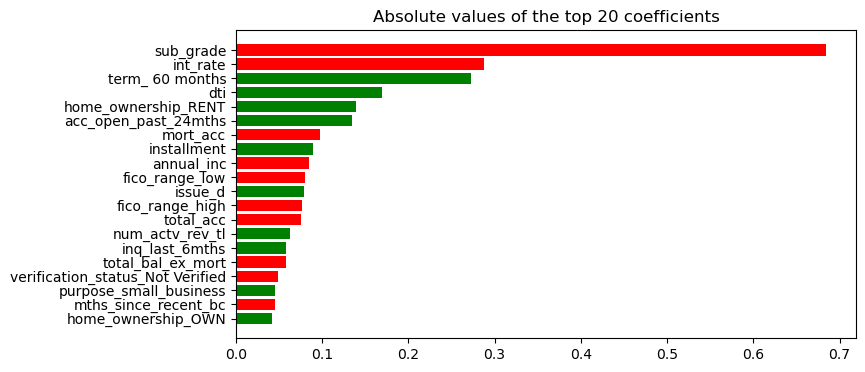

In [26]:

sorted_coeffs = lassocv_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs.iloc[-20:]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of the top 20 coefficients")
plt.savefig("graphs/lassocv_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

34.551072945922186 	 this is the optimal lambda parameter


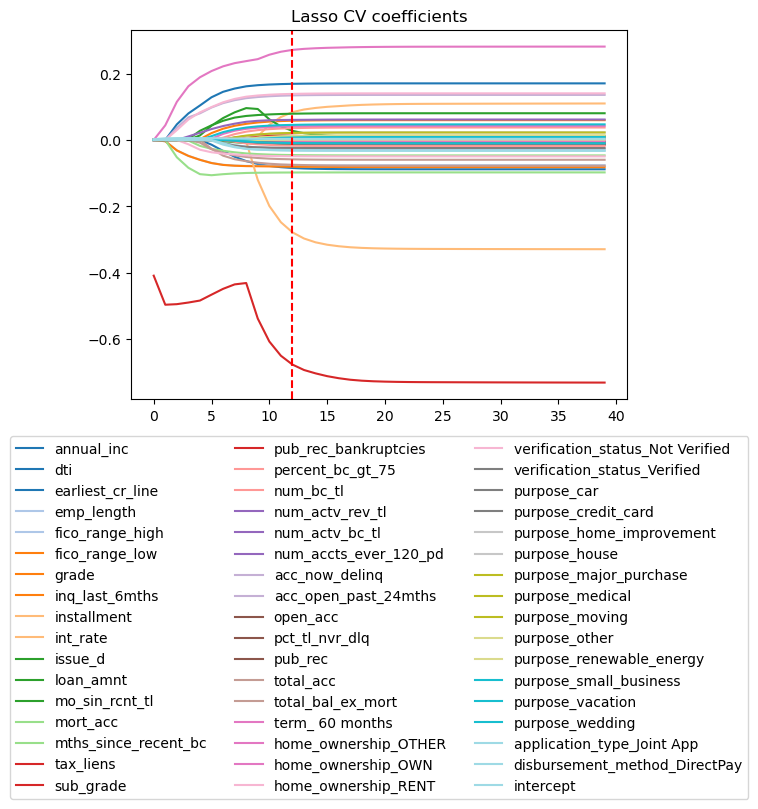

In [27]:
print((lassocv_model.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(lassocv_model.feature_names_in_)
pd.DataFrame(lassocv_model.coefs_paths_[1].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(lassocv_model.Cs_ == lassocv_model.C_),linestyle="--",color="red")
# plt.xticks(range(1,41),labels = lassocv_model.Cs_,size = 5)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1),ncols=3)
plt.title("Lasso CV coefficients")
plt.show()

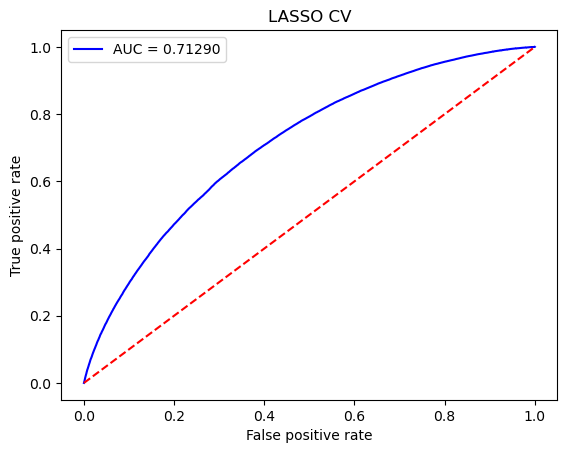

In [28]:
lassocv_fpr, lassocv_tpr, lassocv_thresholds = roc_curve(y_val, lassocv_phat_val)
lassocv_auc_val = roc_auc_score(y_val, lassocv_phat_val)
plt.plot(lassocv_fpr,lassocv_tpr, "b", label = "AUC = %0.5f"%lassocv_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("LASSO CV")
plt.show()

### Ridge

In [29]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.

#parameter cv= number of folds to use in cross validation

ridgecv_model = LogisticRegressionCV(penalty="l2", solver="saga", Cs = 40, cv = 5, max_iter = 3500, n_jobs = -1,verbose = 0)
ridgecv_model.fit(X_train,y_train)

LogisticRegressionCV(Cs=40, cv=5, max_iter=3500, n_jobs=-1, solver='saga')

In [30]:
ridgecv_yhat_val = ridgecv_model.predict(X_val)
ridgecv_phat_val = ridgecv_model.predict_proba(X_val)[:,1]

print("num of coefs that have been shrunk to 0: ", (ridgecv_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(ridgecv_model.coef_).sum())
print("L2 norm of coefficients: ", (ridgecv_model.coef_**2).sum())
print("acc_score function from sklearn: ", accuracy_score(y_val,ridgecv_yhat_val))
print(classification_report(y_val,ridgecv_yhat_val))
ridgecv_cm = pd.DataFrame(confusion_matrix(y_val, ridgecv_yhat_val))
ridgecv_cm.index.name="actual"
ridgecv_cm.columns.name="predicted"
print(ridgecv_cm)
print("Coefficients of Ridge")
ridgecv_coeffs = (pd.Series(ridgecv_model.coef_[0], index = ridgecv_model.feature_names_in_)).sort_values()
ridgecv_coeffs


num of coefs that have been shrunk to 0:  0
L1 norm of coefficients:  3.138636329756492
L2 norm of coefficients:  0.8568818073252743
acc_score function from sklearn:  0.6564877894477866
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181478  94325
1           22959  42664
Coefficients of Ridge


sub_grade                          -0.723905
int_rate                           -0.324873
mort_acc                           -0.097528
annual_inc                         -0.088041
fico_range_low                     -0.079923
fico_range_high                    -0.077701
total_acc                          -0.077520
total_bal_ex_mort                  -0.059538
verification_status_Not Verified   -0.049347
mths_since_recent_bc               -0.046379
disbursement_method_DirectPay      -0.032658
application_type_Joint App         -0.031936
emp_length                         -0.027274
purpose_credit_card                -0.024248
num_bc_tl                          -0.017890
pub_rec_bankruptcies               -0.014540
mo_sin_rcnt_tl                     -0.012447
verification_status_Verified       -0.012140
purpose_car                        -0.010575
purpose_wedding                    -0.009807
pct_tl_nvr_dlq                     -0.005338
earliest_cr_line                   -0.004667
home_owner

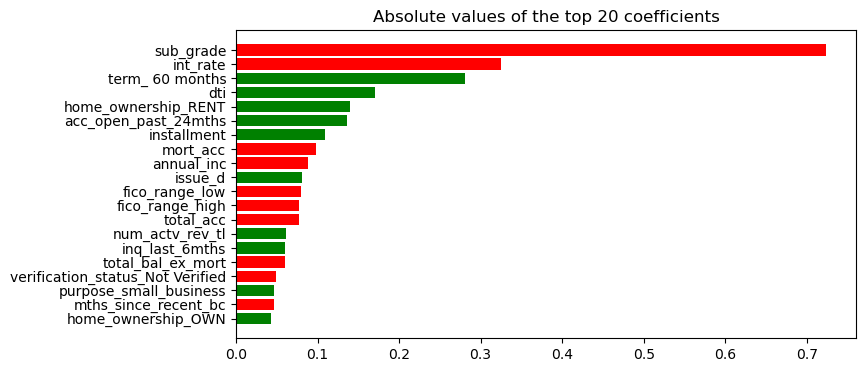

In [31]:
sorted_coeffs = ridgecv_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs.iloc[-20:]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of the top 20 coefficients")
plt.savefig("graphs/ridgecv_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

5.2233450742668435 	 this is the optimal lambda parameter


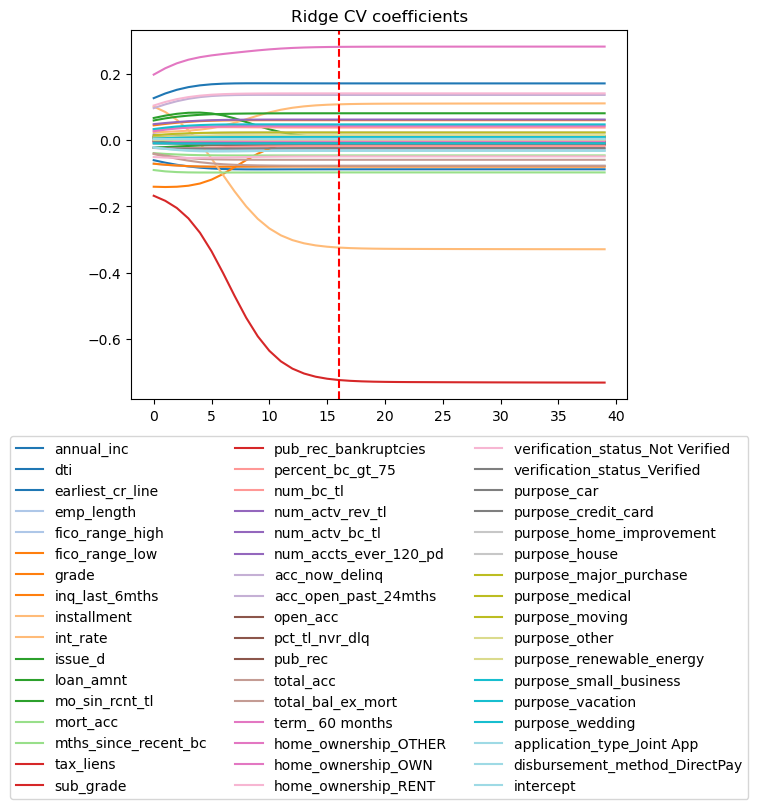

In [32]:
print((ridgecv_model.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(ridgecv_model.feature_names_in_)
pd.DataFrame(ridgecv_model.coefs_paths_[1].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(ridgecv_model.Cs_ == ridgecv_model.C_),linestyle="--",color="red")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1),ncols=3)
plt.title("Ridge CV coefficients")
plt.show()

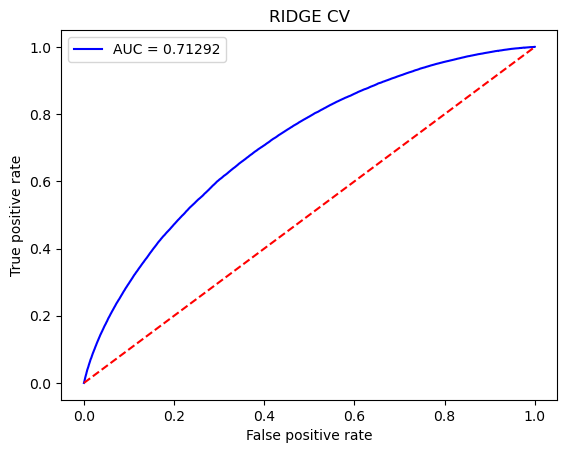

In [33]:
ridgecv_fpr, ridgecv_tpr, ridgecv_thresholds = roc_curve(y_val, ridgecv_phat_val)
ridgecv_auc_val = roc_auc_score(y_val, ridgecv_phat_val)
plt.plot(ridgecv_fpr,ridgecv_tpr, "b", label = "AUC = %0.5f"%ridgecv_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("RIDGE CV")
plt.show()

### Elastic net

In [34]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.

#parameter cv= number of folds to use in cross validation

elasticnetcv_model = LogisticRegressionCV(penalty="elasticnet", solver="saga", Cs = 40, cv = 5, 
                                          l1_ratios= [0.5], max_iter = 3500, n_jobs = -1,verbose = 0)
elasticnetcv_model.fit(X_train,y_train)

LogisticRegressionCV(Cs=40, cv=5, l1_ratios=[0.5], max_iter=3500, n_jobs=-1,
                     penalty='elasticnet', solver='saga')

In [36]:
elasticnetcv_yhat_val = elasticnetcv_model.predict(X_val)
elasticnetcv_phat_val = elasticnetcv_model.predict_proba(X_val)[:,1]
print("num of coefs that have been shrunk to 0: ", (elasticnetcv_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(elasticnetcv_model.coef_).sum())
print("L2 norm of coefficients: ", (elasticnetcv_model.coef_**2).sum())
print("accuracy: ", accuracy_score(y_val,elasticnetcv_yhat_val))
print(classification_report(y_val,elasticnetcv_yhat_val))
elasticnetcv_cm = pd.DataFrame(confusion_matrix(y_val, elasticnetcv_yhat_val))
elasticnetcv_cm.index.name="actual"
elasticnetcv_cm.columns.name="predicted"
print(elasticnetcv_cm)
print("coefficients of Elastic net")
elasticnetcv_coeffs = (pd.Series(elasticnetcv_model.coef_[0], index = elasticnetcv_model.feature_names_in_)).sort_values()
elasticnetcv_coeffs

num of coefs that have been shrunk to 0:  2
L1 norm of coefficients:  2.9923646215444646
L2 norm of coefficients:  0.7517134206550572
accuracy:  0.6566518074194702
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181560  94243
1           22985  42638
coefficients of Elastic net


sub_grade                          -0.676126
int_rate                           -0.279662
mort_acc                           -0.097717
annual_inc                         -0.085501
fico_range_low                     -0.079666
fico_range_high                    -0.077992
total_acc                          -0.075675
total_bal_ex_mort                  -0.058396
verification_status_Not Verified   -0.049241
mths_since_recent_bc               -0.045849
disbursement_method_DirectPay      -0.032120
application_type_Joint App         -0.031679
emp_length                         -0.026471
purpose_credit_card                -0.024022
num_bc_tl                          -0.016756
mo_sin_rcnt_tl                     -0.012191
verification_status_Verified       -0.011518
pub_rec_bankruptcies               -0.010907
purpose_car                        -0.010120
purpose_wedding                    -0.009358
pct_tl_nvr_dlq                     -0.005110
earliest_cr_line                   -0.003163
home_owner

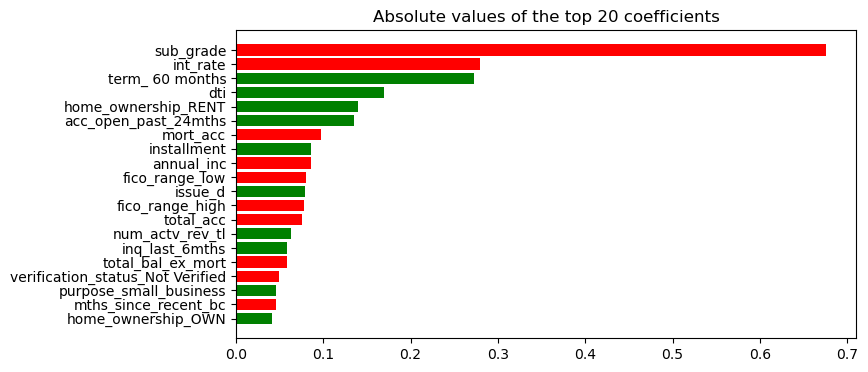

In [37]:
sorted_coeffs = elasticnetcv_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs.iloc[-20:]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of the top 20 coefficients")
plt.savefig("graphs/elasticnetcv_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

55.41020330009492 	 this is the optimal lambda parameter


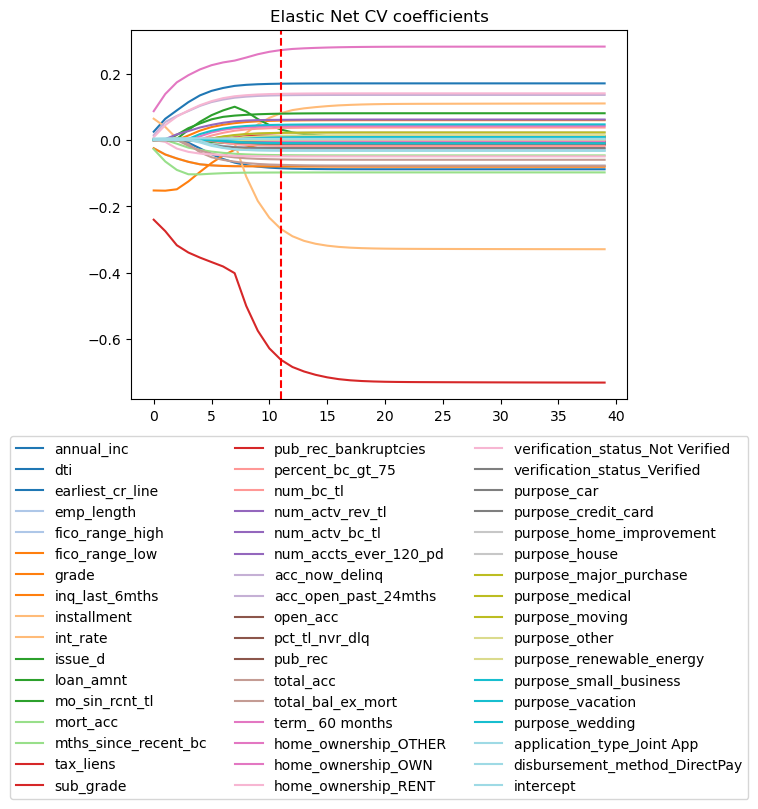

In [38]:
print((elasticnetcv_model.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(elasticnetcv_model.feature_names_in_)
pd.DataFrame(elasticnetcv_model.coefs_paths_[1][:,:,0,:].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(elasticnetcv_model.Cs_ == elasticnetcv_model.C_),linestyle="--",color="red")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1),ncols=3)
plt.title("Elastic Net CV coefficients")
plt.show()

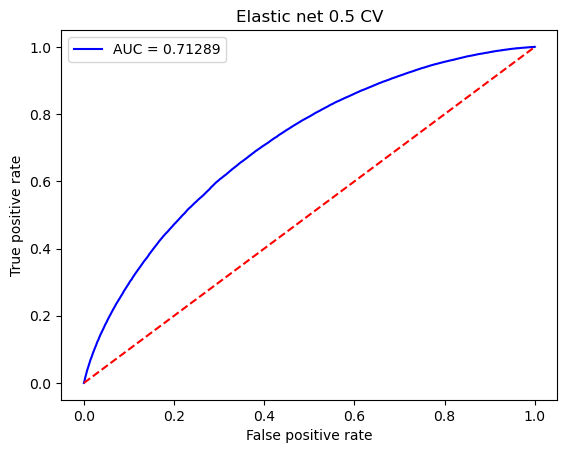

In [39]:
elasticnetcv_fpr, elasticnetcv_tpr, elasticnetcv_thresholds = roc_curve(y_val, elasticnetcv_phat_val)
elasticnetcv_auc_val = roc_auc_score(y_val, elasticnetcv_phat_val)
plt.plot(elasticnetcv_fpr,elasticnetcv_tpr, "b", label = "AUC = %0.5f"%elasticnetcv_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Elastic net 0.5 CV")
plt.show()

### Elastic net with a high penalty

we chose a high regularization parameter to force the model to pick only a few features

In [40]:
elasticnetcv_model.Cs_[:13]

array([0.0001    , 0.00016037, 0.00025719, 0.00041246, 0.00066147,
       0.00106082, 0.00170125, 0.00272833, 0.00437548, 0.00701704,
       0.01125336, 0.01804722, 0.02894266])

In [41]:
from sklearn.linear_model import LogisticRegression
en_highreg_model = LogisticRegression(penalty = "elasticnet", l1_ratio = 0.9, C = 0.00035,
                                  max_iter=3500, solver = "saga", n_jobs=-1)

en_highreg_model.fit(X_train,y_train)

LogisticRegression(C=0.00035, l1_ratio=0.9, max_iter=3500, n_jobs=-1,
                   penalty='elasticnet', solver='saga')

In [42]:
en_highreg_yhat_val = en_highreg_model.predict(X_val)
en_highreg_phat_val = en_highreg_model.predict_proba(X_val)[:,1]
print("num of coefs that have been shrunk to 0: ", (en_highreg_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(en_highreg_model.coef_).sum())
print("L2 norm of coefficients: ", (en_highreg_model.coef_**2).sum())
print("accuracy: ", accuracy_score(y_val,en_highreg_yhat_val))
print(classification_report(y_val,en_highreg_yhat_val))
en_highreg_cm = pd.DataFrame(confusion_matrix(y_val, en_highreg_yhat_val))
en_highreg_cm.index.name="actual"
en_highreg_cm.columns.name="predicted"
print(en_highreg_cm)
print("coefficients of Elastic net")
en_highreg_coeffs = (pd.Series(en_highreg_model.coef_[0], index = en_highreg_model.feature_names_in_)).sort_values()
en_highreg_coeffs

num of coefs that have been shrunk to 0:  37
L1 norm of coefficients:  1.1410336912784043
L2 norm of coefficients:  0.2857115027108448
accuracy:  0.6581543291957848
              precision    recall  f1-score   support

           0       0.88      0.66      0.76    275803
           1       0.31      0.63      0.41     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.77      0.66      0.69    341426

predicted       0      1
actual                  
0          183330  92473
1           24242  41381
coefficients of Elastic net


sub_grade                          -0.471943
mort_acc                           -0.090515
fico_range_low                     -0.052721
fico_range_high                    -0.052415
verification_status_Not Verified   -0.020867
grade                              -0.011597
mths_since_recent_bc               -0.007813
annual_inc                          0.000000
total_bal_ex_mort                   0.000000
home_ownership_OTHER                0.000000
home_ownership_OWN                  0.000000
verification_status_Verified        0.000000
purpose_car                         0.000000
purpose_credit_card                 0.000000
purpose_home_improvement            0.000000
purpose_house                       0.000000
purpose_major_purchase              0.000000
purpose_medical                     0.000000
purpose_moving                      0.000000
purpose_other                       0.000000
purpose_renewable_energy            0.000000
purpose_small_business              0.000000
purpose_va

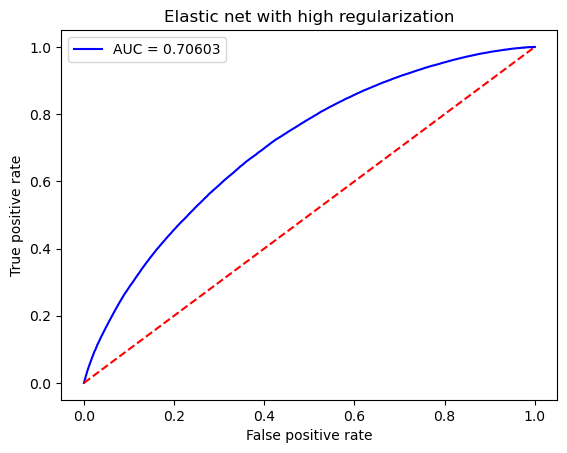

In [43]:
en_highreg_fpr, en_highreg_tpr, en_highreg_thresholds = roc_curve(y_val, en_highreg_phat_val)
en_highreg_auc_val = roc_auc_score(y_val, en_highreg_phat_val)
plt.plot(en_highreg_fpr,en_highreg_tpr, "b", label = "AUC = %0.5f"%en_highreg_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Elastic net with high regularization")
plt.show()

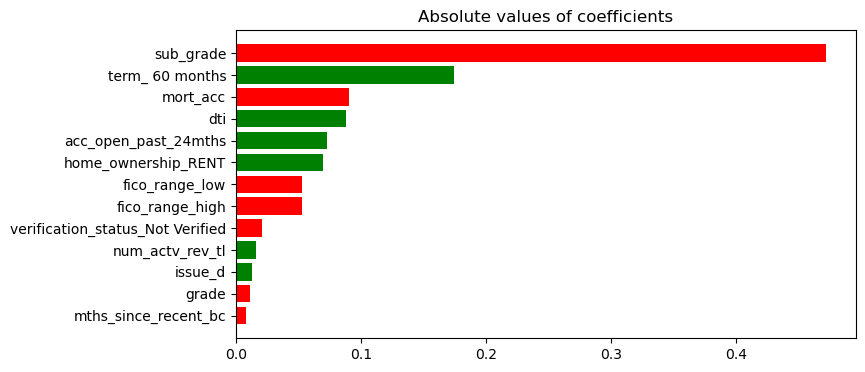

In [75]:
sorted_coeffs = en_highreg_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs[sorted_coeffs.abs_value !=0]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of coefficients")
plt.savefig("graphs/en_highreg_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

### Correlation between models' coefficients

In [45]:
pd.DataFrame({"log_reg":logreg_coeffs,
              "Lasso_CV":lassocv_coeffs,
              "Ridge_CV":ridgecv_coeffs,
              "ElasticNetCV":elasticnetcv_coeffs,
              "ElasticNet_High":en_highreg_coeffs}).corr()

,log_reg,Lasso_CV,Ridge_CV,ElasticNetCV,ElasticNet_High
log_reg,1.000000,0.998967,0.999989,0.998530,0.899663
Lasso_CV,0.998967,1.000000,0.999138,0.999946,0.908107
Ridge_CV,0.999989,0.999138,1.000000,0.998737,0.900004
ElasticNetCV,0.998530,0.999946,0.998737,1.000000,0.909033
ElasticNet_High,0.899663,0.908107,0.900004,0.909033,1.000000


## Tree based models

### Random forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

random_forest = RandomForestClassifier(n_estimators=1500, random_state=0, n_jobs= -1)

random_forest.fit(X_train, y_train)

random_forest_phat_val = random_forest.predict_proba(X_val)[:,1]
random_forest_yhat_val = random_forest.predict(X_val)


In [47]:
print(f"accuracy: {accuracy_score(y_val,random_forest_yhat_val):5f}",
      classification_report(y_val, random_forest_yhat_val),sep="\n")

random_forest_cm = pd.DataFrame(confusion_matrix(y_val, random_forest_yhat_val))
random_forest_cm.index.name="actual"
random_forest_cm.columns.name="predicted"
print(random_forest_cm)
print("confusion matrix")



accuracy: 0.645865
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    275803
           1       0.31      0.68      0.43     65623

    accuracy                           0.65    341426
   macro avg       0.60      0.66      0.59    341426
weighted avg       0.78      0.65      0.68    341426

predicted       0       1
actual                   
0          175592  100211
1           20700   44923
confusion matrix


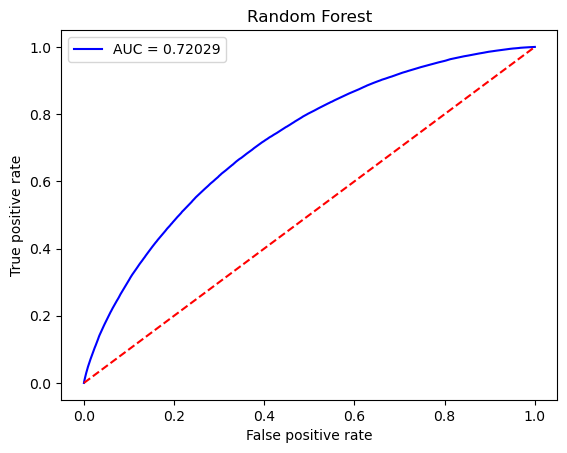

In [48]:
random_forest_fpr, random_forest_tpr, random_forest_thresholds = roc_curve(y_val, random_forest_phat_val)
random_forest_auc_val = roc_auc_score(y_val, random_forest_phat_val)
plt.plot(random_forest_fpr,random_forest_tpr, "b", label = "AUC = %0.5f"%random_forest_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Random Forest")
plt.savefig("graphs/rand_forest_roc.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

In [49]:
# Feature importance

random_forest_ranking = pd.DataFrame({"feature":random_forest.feature_names_in_,
                                     "importance":random_forest.feature_importances_}).set_index("feature")
random_forest_ranking.sort_values("importance",inplace=True,ascending=True)

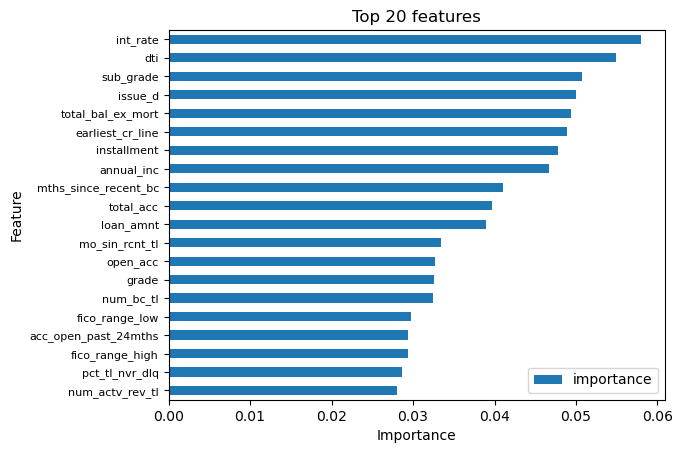

In [50]:

random_forest_ranking.iloc[-20:].plot(kind='barh',width= .5)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 features')
plt.yticks(fontsize=8)
plt.savefig("graphs/rand_forest_features.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

### XGBOOST


In [51]:
from xgboost import XGBClassifier

xgboost_model = XGBClassifier(objective = "binary:logistic",eval_metric = "auc", n_estimators = 15000, 
                              n_jobs = -1, random_state = 0)

xgboost_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=15000, n_jobs=-1,
              num_parallel_tree=None, random_state=0, ...)

In [52]:
xgboost_yhat_val = xgboost_model.predict(X_val)
xgboost_phat_val = xgboost_model.predict_proba(X_val)[:,1]

print("accuracy: ", accuracy_score(y_val,xgboost_yhat_val))
print(classification_report(y_val,xgboost_yhat_val))
xgboost_cm = pd.DataFrame(confusion_matrix(y_val, xgboost_yhat_val))
xgboost_cm.index.name="actual"
xgboost_cm.columns.name="predicted"
print(xgboost_cm)


accuracy:  0.6230046920855471
              precision    recall  f1-score   support

           0       0.88      0.62      0.73    275803
           1       0.29      0.64      0.39     65623

    accuracy                           0.62    341426
   macro avg       0.58      0.63      0.56    341426
weighted avg       0.76      0.62      0.66    341426

predicted       0       1
actual                   
0          170842  104961
1           23755   41868


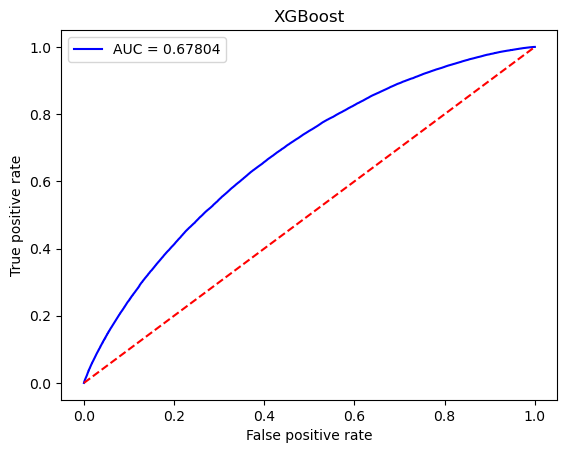

In [53]:
xgboost_fpr, xgboost_tpr, xgboost_thresholds = roc_curve(y_val, xgboost_phat_val)
xgboost_auc_val = roc_auc_score(y_val, xgboost_phat_val)
plt.plot(xgboost_fpr,xgboost_tpr, "b", label = "AUC = %0.5f"%xgboost_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("XGBoost")
plt.savefig("graphs/xgboost_roc.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

In [54]:

xgboost_ranking = pd.DataFrame({"feature":xgboost_model.feature_names_in_,
                                     "importance":xgboost_model.feature_importances_}).set_index("feature")
xgboost_ranking.sort_values("importance",inplace=True,ascending=True)

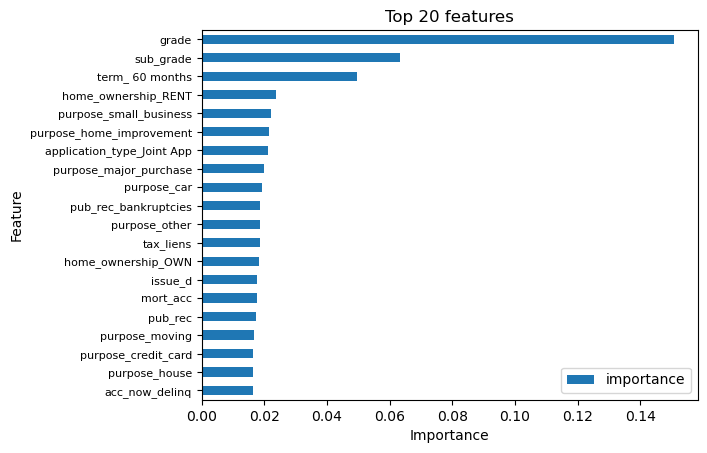

In [55]:
xgboost_ranking.iloc[-20:].plot(kind='barh',width= .5)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 features')
plt.yticks(fontsize=8)
plt.savefig("graphs/xgboost_features.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

### BART


In [56]:
# we used R to fit the BART model

bart_phat_val = pd.read_csv("C:\\Users\\giuse\\DatiR\\lending_club\\bart_phat_val.csv",index_col= 0)
bart_phat_val.index = y_val.index
# bart_phat_val = np.random.shuffle(np.asarray(bart_phat_val.x))
bart_phat_val.head()

,x
666509,0.615914
113669,0.364615
1034907,0.165571
1190916,0.568667
107094,0.545671


In [57]:
bart_yhat_val = bart_phat_val > 0.5

print("accuracy", accuracy_score(y_val,bart_yhat_val))
print(classification_report(y_val,bart_yhat_val))
bart_cm = pd.DataFrame(confusion_matrix(y_val, bart_yhat_val))
bart_cm.index.name="actual"
bart_cm.columns.name="predicted"
print(bart_cm)


accuracy 0.6432462671266981
              precision    recall  f1-score   support

           0       0.90      0.63      0.74    275803
           1       0.31      0.69      0.43     65623

    accuracy                           0.64    341426
   macro avg       0.60      0.66      0.58    341426
weighted avg       0.78      0.64      0.68    341426

predicted       0       1
actual                   
0          174382  101421
1           20384   45239


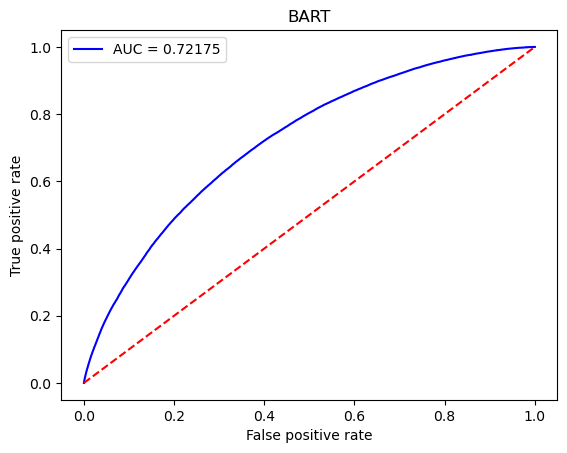

In [58]:
#Roc Curve
bart_fpr, bart_tpr, bart_thresholds = roc_curve(y_val, bart_phat_val)
bart_auc_val = roc_auc_score(y_val, bart_phat_val)
plt.plot(bart_fpr,bart_tpr, "b", label = "AUC = %0.5f"%bart_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("BART")
plt.savefig("graphs/bart_roc.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

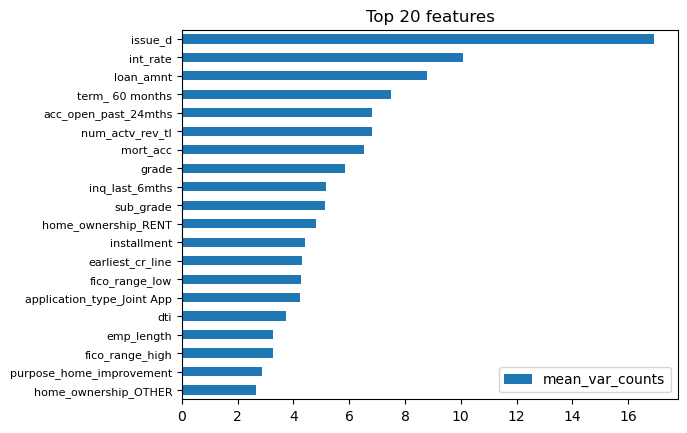

In [59]:

#feature importance

bart_mean_var_counts = pd.read_csv("C:\\Users\\giuse\\DatiR\\lending_club\\mean_var_counts.csv", index_col= 0)
bart_mean_var_counts.rename(columns={"x":"mean_var_counts"},inplace = True)
bart_mean_var_counts.rename(index= {"term_.60.months" : "term_ 60 months",
                                     "verification_status_Not.Verified" : "verification_status_Not Verified", 
                                     "application_type_Joint.App":"application_type_Joint App"}, inplace = True)


bart_mean_var_counts.sort_values(by= "mean_var_counts").iloc[-20:].plot(kind='barh')
plt.title('Top 20 features')
plt.yticks(fontsize=8)
plt.savefig("graphs/bart_features.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

## Model performance side by side

In [60]:
roc_auc_list = [logreg_auc_val, lassocv_auc_val, ridgecv_auc_val, elasticnetcv_auc_val, en_highreg_auc_val, random_forest_auc_val, xgboost_auc_val, bart_auc_val]

accuracy_list = [accuracy_score(y_val,model_yhat_val) for model_yhat_val in (logReg_yhat_val, lassocv_yhat_val, ridgecv_yhat_val, elasticnetcv_yhat_val, en_highreg_yhat_val, random_forest_yhat_val, xgboost_yhat_val, bart_yhat_val)]

TP_list = [logreg_cm.loc[1,1], lassocv_cm.loc[1,1], ridgecv_cm.loc[1,1], elasticnetcv_cm.loc[1,1], en_highreg_cm.loc[1,1], random_forest_cm.loc[1,1], xgboost_cm.loc[1,1], bart_cm.loc[1,1]]

TN_list = [logreg_cm.loc[0,0], lassocv_cm.loc[0,0], ridgecv_cm.loc[0,0], elasticnetcv_cm.loc[0,0], en_highreg_cm.loc[0,0], random_forest_cm.loc[0,0], xgboost_cm.loc[0,0], bart_cm.loc[0,0]]

FP_list = [logreg_cm.loc[0,1], lassocv_cm.loc[0,1], ridgecv_cm.loc[0,1], elasticnetcv_cm.loc[0,1], en_highreg_cm.loc[0,1], random_forest_cm.loc[0,1], xgboost_cm.loc[0,1], bart_cm.loc[0,1]]

FN_list = [logreg_cm.loc[1,0], lassocv_cm.loc[1,0], ridgecv_cm.loc[1,0], elasticnetcv_cm.loc[1,0], en_highreg_cm.loc[1,0], random_forest_cm.loc[1,0], xgboost_cm.loc[1,0], bart_cm.loc[1,0]]

model_comparison = pd.DataFrame({"model":["Logistic Regression","LASSO","Ridge","Elastic Net","Elastic Net High","Random Forest","XGboost","Bart"],
              "ROC_AUC":roc_auc_list,
              "Accuracy":accuracy_list,
              "True_Positives":TP_list,
              "True_Negatives":TN_list,
              "False_Positives":FP_list,
              "False_Negatives":FN_list}).set_index("model")

In [61]:
model_comparison

,ROC_AUC,Accuracy,True_Positives,True_Negatives,False_Positives,False_Negatives
model,,,,,,
Logistic Regression,0.712924,0.656494,42661,181483,94320,22962
LASSO,0.712897,0.656602,42625,181556,94247,22998
Ridge,0.712924,0.656488,42664,181478,94325,22959
Elastic Net,0.712895,0.656652,42638,181560,94243,22985
Elastic Net High,0.706030,0.658154,41381,183330,92473,24242
Random Forest,0.720287,0.645865,44923,175592,100211,20700
XGboost,0.678044,0.623005,41868,170842,104961,23755
Bart,0.721746,0.643246,45239,174382,101421,20384


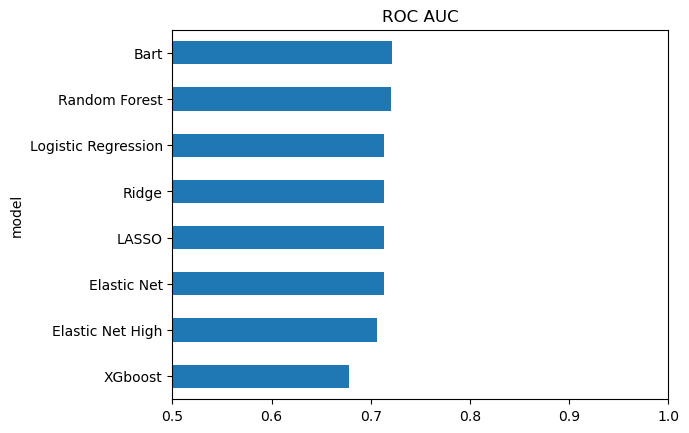

In [62]:
model_comparison.ROC_AUC.sort_values().plot(kind="barh")
plt.title("ROC AUC")
plt.xlim((0.5,1))
plt.savefig("graphs/AUC_model_comparison.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

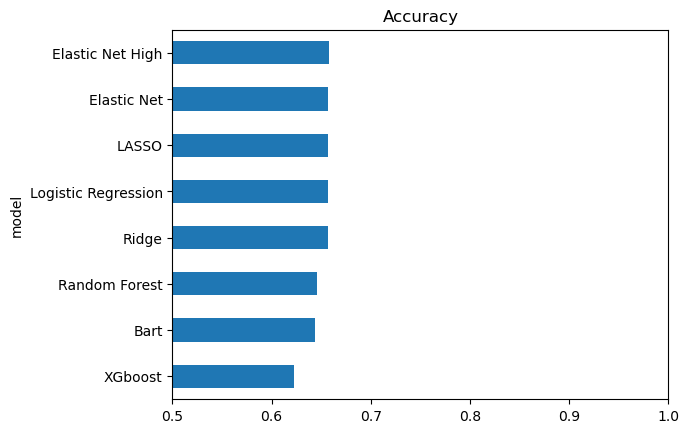

In [63]:
model_comparison.Accuracy.sort_values().plot(kind="barh")
plt.title("Accuracy")
plt.xlim((0.5,1))
plt.savefig("graphs/Accuracy_model_comparison.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

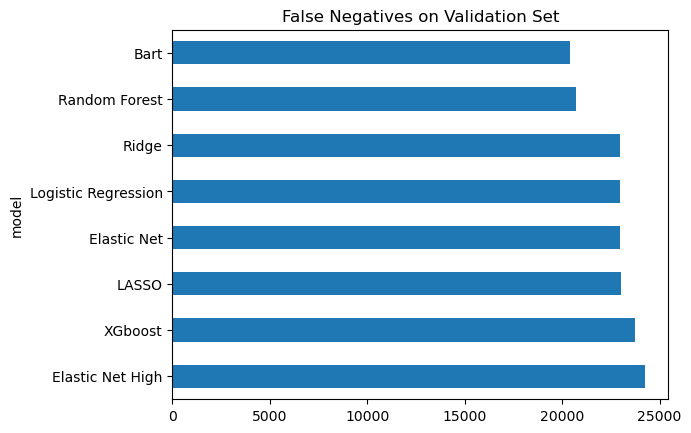

In [64]:
model_comparison.False_Negatives.sort_values(ascending=False).plot(kind="barh")
plt.title("False Negatives on Validation Set")
plt.savefig("graphs/FN_model_comparison.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

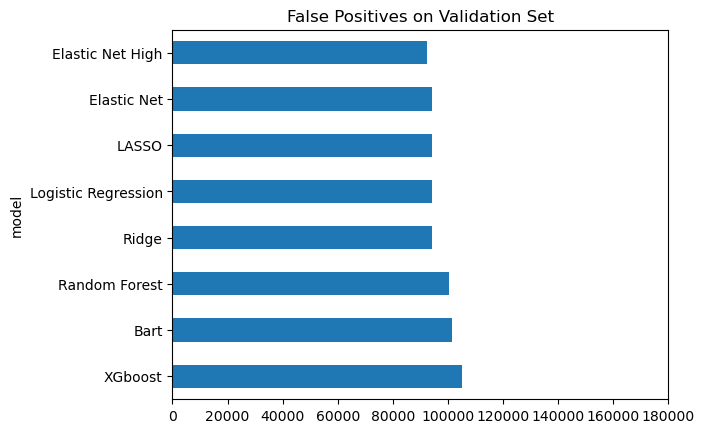

In [65]:
model_comparison.False_Positives.sort_values(ascending=False).plot(kind="barh")
plt.title("False Positives on Validation Set")
plt.xlim((0,180000))
plt.savefig("graphs/FP_model_comparison.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')

plt.show()

Selecting a threshold


In this application, we can assume that false negatives, i.e. type II errors, are much worse than false positives. A loan that defaults but is undetected by our model has worse consequences than a loan that doesn't default but our model doesn't like. We define a loss function to select a threshold that gives more weight to false negatives.

$\ell(\theta) = \theta\times FPR + (1-\theta)\times FNR$

Where $\theta$ is a parameter we set that allows us to make false negatives more costly. We pick $ 0.4$

In [149]:
def get_cm_given_theta(model_fpr, model_tpr, model_thresholds, model_phat_val, theta = 0.4, val = True):
    if val:
        y_true = y_val
    else:
        y_true = y_test
    ell = model_fpr * theta + (1-theta)*(1-model_tpr)
    lowest_ell = np.argmin(ell)
    optimal_threshold = model_thresholds[lowest_ell]
    cm_optimal_threshold = pd.DataFrame(confusion_matrix(y_true, model_phat_val > optimal_threshold))
    cm_optimal_threshold.index.name="actual"
    cm_optimal_threshold.columns.name="predicted"
    print("selected threshold is "+str(optimal_threshold))
    return cm_optimal_threshold

In [150]:
fprs = [logReg_fpr, lassocv_fpr, ridgecv_fpr, elasticnetcv_fpr, en_highreg_fpr, random_forest_fpr, xgboost_fpr, bart_fpr]
tprs = [logReg_tpr, lassocv_tpr, ridgecv_tpr, elasticnetcv_tpr, en_highreg_tpr, random_forest_tpr, xgboost_tpr, bart_tpr]
thresholds = [logReg_thresholds, lassocv_thresholds, ridgecv_thresholds, elasticnetcv_thresholds, en_highreg_thresholds, random_forest_thresholds, xgboost_thresholds, bart_thresholds]
phat_vals = [logreg_phat_val, lassocv_phat_val, ridgecv_phat_val, elasticnetcv_phat_val, en_highreg_phat_val, random_forest_phat_val, xgboost_phat_val, bart_phat_val]

In [151]:
optimal_t_cm = {model : get_cm_given_theta(fprs, tprs, t, phat) for model,fprs, tprs, t, phat in 
                zip(model_comparison.index,fprs, tprs, thresholds, phat_vals)}

selected threshold is 0.39072805657414594
selected threshold is 0.3928426452387631
selected threshold is 0.39083083873634156
selected threshold is 0.39305919785063076
selected threshold is 0.40087453597659733
selected threshold is 0.41533333333333333
selected threshold is 0.054599497
selected threshold is 0.409396398346668


In [152]:
optimal_cm_sidebyside = pd.DataFrame({"model":["Logistic Regression","LASSO","Ridge","Elastic Net","Elastic Net High","Random Forest","XGboost","Bart"],
              "True_Positives":[optimal_t_cm[model].loc[1,1] for model in model_comparison.index],
              "True_Negatives":[optimal_t_cm[model].loc[0,0] for model in model_comparison.index],
              "False_Positives":[optimal_t_cm[model].loc[0,1] for model in model_comparison.index],
              "False_Negatives":[optimal_t_cm[model].loc[1,0] for model in model_comparison.index]}).set_index("model")
optimal_cm_sidebyside

,True_Positives,True_Negatives,False_Positives,False_Negatives
model,,,,
Logistic Regression,54878,121438,154365,10745
LASSO,54746,122423,153380,10877
Ridge,54869,121490,154313,10754
Elastic Net,54727,122513,153290,10896
Elastic Net High,55489,115686,160117,10134
Random Forest,54425,127446,148357,11198
XGboost,56173,99214,176589,9450
Bart,54328,128916,146887,11295


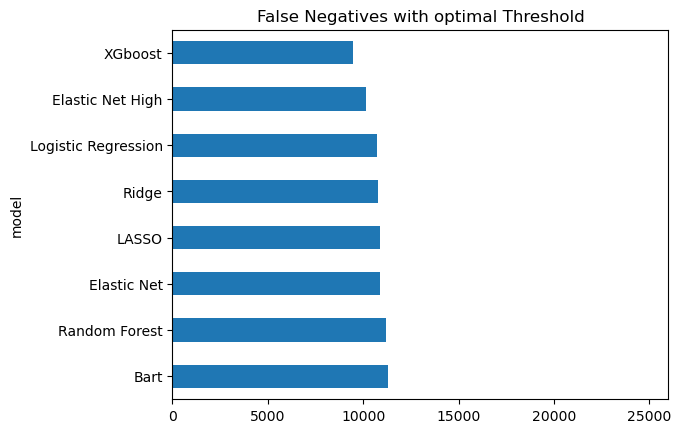

In [153]:
optimal_cm_sidebyside.False_Negatives.sort_values(ascending=False).plot(kind="barh")
plt.title("False Negatives with optimal Threshold")
plt.xlim((0,26000))
plt.savefig("graphs/FN_optimal_T.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

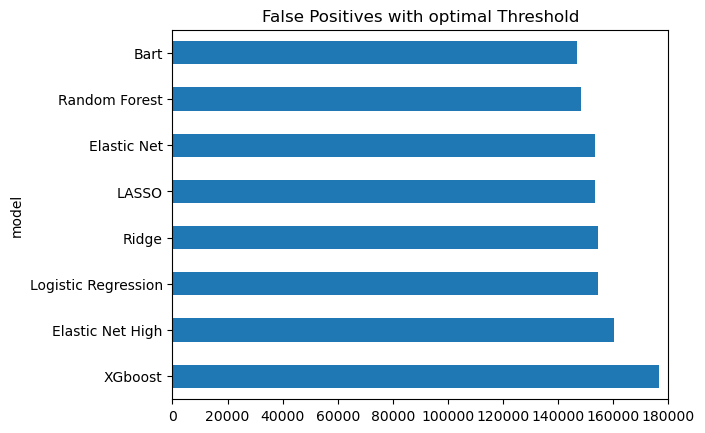

In [71]:
optimal_cm_sidebyside.False_Positives.sort_values(ascending=False).plot(kind="barh")
plt.title("False Positives with optimal Threshold")
plt.xlim((0,180000))
plt.savefig("graphs/FP_optimal_T.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

## Feature Ranking


Do models agree on which features are the most important?

In [72]:
models_features_importance = [logreg_coeffs.apply(np.abs),
                            lassocv_coeffs.apply(np.abs),
                            ridgecv_coeffs.apply(np.abs),
                            elasticnetcv_coeffs.apply(np.abs),
                            en_highreg_coeffs.apply(np.abs),
                            random_forest_ranking,
                            xgboost_ranking, 
                            bart_mean_var_counts]

models_features_importance = [features.rank() for features in models_features_importance]

models_features_importance = pd.concat(models_features_importance,axis = "columns")
models_features_importance = models_features_importance.T
models_features_importance.index = model_comparison.index
models_features_importance=models_features_importance.T
models_features_importance.corr()

model,Logistic Regression,LASSO,Ridge,Elastic Net,Elastic Net High,Random Forest,XGboost,Bart
model,,,,,,,,
Logistic Regression,1.000000,0.967082,0.999712,0.967082,0.612299,0.478319,0.127203,0.494070
LASSO,0.967082,1.000000,0.970011,0.999616,0.590274,0.489135,0.061850,0.533698
Ridge,0.999712,0.970011,1.000000,0.970107,0.609809,0.480528,0.121056,0.493205
Elastic Net,0.967082,0.999616,0.970107,1.000000,0.590274,0.494226,0.057720,0.536291
Elastic Net High,0.612299,0.590274,0.609809,0.590274,1.000000,0.374601,0.258430,0.575817
Random Forest,0.478319,0.489135,0.480528,0.494226,0.374601,1.000000,-0.232557,0.562257
XGboost,0.127203,0.061850,0.121056,0.057720,0.258430,-0.232557,1.000000,0.002737
Bart,0.494070,0.533698,0.493205,0.536291,0.575817,0.562257,0.002737,1.000000


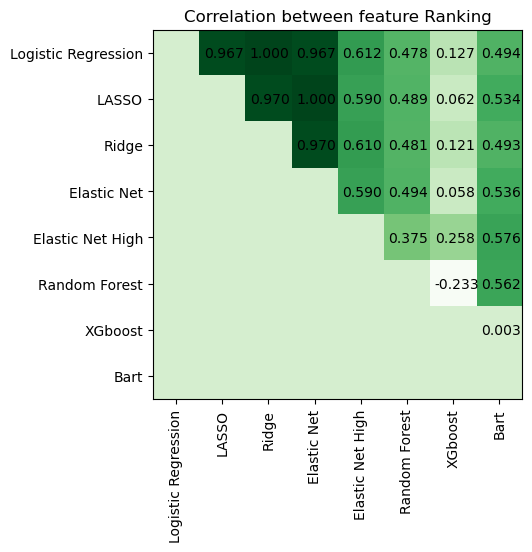

In [73]:
# Plotting the heat map of the correlation matrix
ranking_corr = models_features_importance.corr()
ranking_corr = ranking_corr* np.tri(8,k=-1).T
plt.imshow(ranking_corr,cmap = "Greens")
plt.xticks(range(8), ranking_corr, rotation = 90)
plt.yticks(range(8), ranking_corr)
for i in range(len(ranking_corr.index)):
    for j in range(len(ranking_corr.index)):
        if i < j :
            plt.text(j-0.4,i+0.1,"{:.3f}".format(ranking_corr.iloc[i,j]),size = 10)
plt.title("Correlation between feature Ranking")
plt.savefig("graphs/Corr_feature_rank.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

As expected, all the linear models, especially the ones with low regularization, strongly agree on which features matter more. XGboost is the model that disagrees most with the others.

Interestingly the Elastic net model with high penalization, that is the model we forced to only pick a few features, has the higher correlation with BART.

Now we select only the most important features, according to mean ranking and its economic meaning. We exclude from the mean the first two linear models, since they are higly correlated

In [133]:
models_features_importance.iloc[:,2:].mean(axis="columns").sort_values(ascending=False).head(10)

sub_grade               48.000000
term_ 60 months         44.333333
issue_d                 42.500000
home_ownership_RENT     41.166667
dti                     40.666667
acc_open_past_24mths    40.666667
mort_acc                40.333333
int_rate                38.500000
fico_range_high         35.666667
num_actv_rev_tl         35.666667
dtype: float64

## Fitting a new model with only the selected features

In [134]:
selected_features = ["int_rate","sub_grade", "term_ 60 months", "dti", "loan_amnt","fico_range_high",
                     "mort_acc","home_ownership_RENT", "home_ownership_OWN","issue_d",
                     'acc_open_past_24mths', 'num_actv_rev_tl']

Elastic net with selected features

We select the top 12 features by mean ranking and we fit an elastic net model. We will test its performance on the test set that so far has not been used.

In [135]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.

#parameter cv= number of folds to use in cross validation

elasticnetcv_model_final = LogisticRegressionCV(penalty="elasticnet", solver="saga", Cs = 60, cv = 5, 
                                          l1_ratios= [0.5], max_iter = 3500, n_jobs = -1,verbose = 0)
elasticnetcv_model_final.fit(X_train[selected_features],y_train)

LogisticRegressionCV(Cs=60, cv=5, l1_ratios=[0.5], max_iter=3500, n_jobs=-1,
                     penalty='elasticnet', solver='saga')

In [136]:
elasticnetcv_final_yhat_test = elasticnetcv_model_final.predict(X_test[selected_features])
elasticnetcv_final_phat_test = elasticnetcv_model_final.predict_proba(X_test[selected_features])[:,1]
print("num of coefs that have been shrunk to 0: ", (elasticnetcv_model_final.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(elasticnetcv_model_final.coef_).sum())
print("L2 norm of coefficients: ", (elasticnetcv_model_final.coef_**2).sum())
print("accuracy: ", accuracy_score(y_test,elasticnetcv_final_yhat_test))
print(classification_report(y_test,elasticnetcv_final_yhat_test))
elasticnetcv_final_cm = pd.DataFrame(confusion_matrix(y_test, elasticnetcv_final_yhat_test))
elasticnetcv_final_cm.index.name="actual"
elasticnetcv_final_cm.columns.name="predicted"
print(elasticnetcv_final_cm)
print("coefficients of Elastic net")
elasticnetcv_final_coeffs = (pd.Series(elasticnetcv_model_final.coef_[0], index = elasticnetcv_model_final.feature_names_in_)).sort_values()
elasticnetcv_final_coeffs

num of coefs that have been shrunk to 0:  0
L1 norm of coefficients:  2.096734895226299
L2 norm of coefficients:  0.7475466482741218
accuracy:  0.657052491156708
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    295221
           1       0.31      0.64      0.42     70593

    accuracy                           0.66    365814
   macro avg       0.60      0.65      0.59    365814
weighted avg       0.77      0.66      0.69    365814

predicted       0       1
actual                   
0          195043  100178
1           25277   45316
coefficients of Elastic net


sub_grade              -0.728110
int_rate               -0.244541
fico_range_high        -0.165850
mort_acc               -0.135261
home_ownership_OWN      0.040140
num_actv_rev_tl         0.040288
loan_amnt               0.065649
issue_d                 0.066400
acc_open_past_24mths    0.116733
dti                     0.133564
home_ownership_RENT     0.138208
term_ 60 months         0.221991
dtype: float64

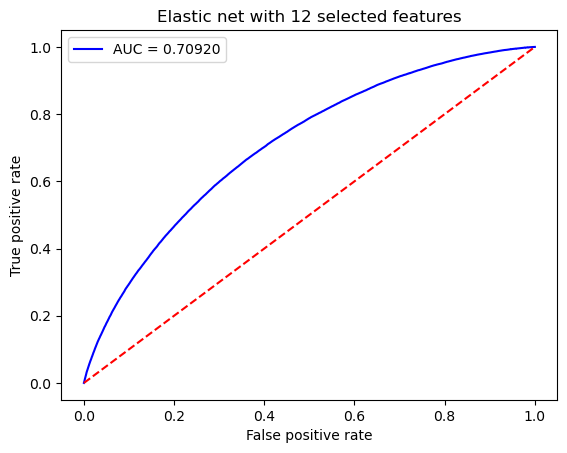

In [141]:
elasticnetcv_test_fpr, elasticnetcv_test_tpr, elasticnetcv_test_thresholds = roc_curve(y_test, elasticnetcv_final_phat_test)
elasticnetcv_test_auc_test = roc_auc_score(y_test, elasticnetcv_final_phat_test)
plt.plot(elasticnetcv_test_fpr,elasticnetcv_test_tpr, "b", label = "AUC = %0.5f"%elasticnetcv_test_auc_test)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Elastic net with 12 selected features")
plt.savefig("graphs/elastic_net_selected_roc.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

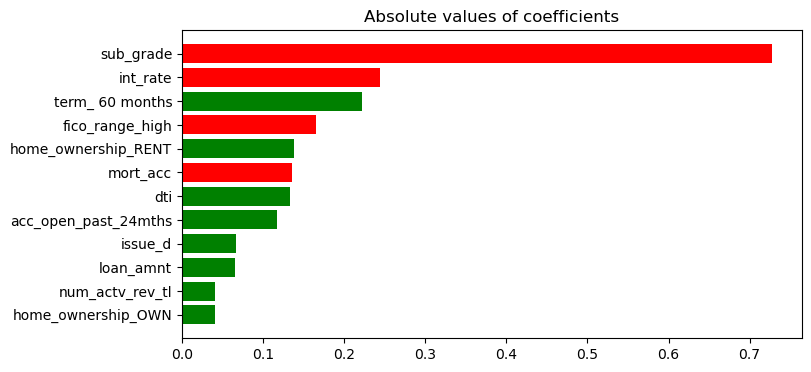

In [142]:
sorted_coeffs = elasticnetcv_final_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs[sorted_coeffs.abs_value !=0]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of coefficients")
plt.savefig("graphs/elastic_net_selected_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

126.38482029342971 	 this is the optimal lambda parameter


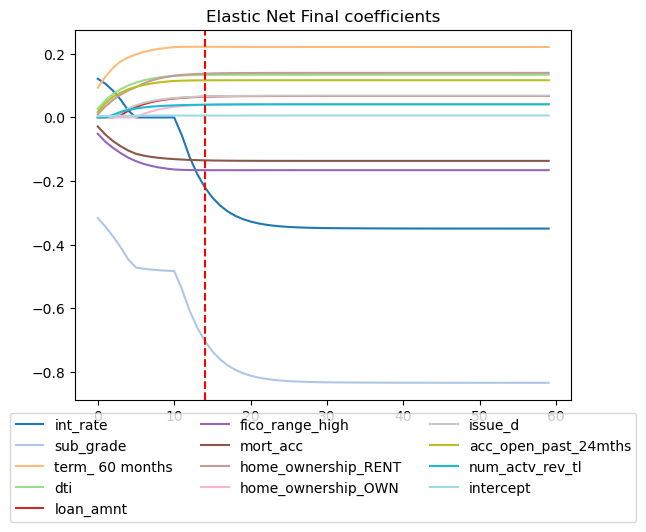

In [143]:
print((elasticnetcv_model_final.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(elasticnetcv_model_final.feature_names_in_)
pd.DataFrame(elasticnetcv_model_final.coefs_paths_[1][:,:,0,:].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(elasticnetcv_model_final.Cs_ == elasticnetcv_model_final.C_),linestyle="--",color="red")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.35),ncols=3)
plt.title("Elastic Net Final coefficients")
plt.savefig("graphs/elastic_net_selected_coeffs_paths.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

In [165]:
opt_t_cm_final = get_cm_given_theta(elasticnetcv_test_fpr, elasticnetcv_test_tpr, elasticnetcv_test_thresholds, elasticnetcv_final_phat_test, val = False)
opt_t_cm_final

selected threshold is 0.3888551989681629


predicted,0,1
actual,,
0,0.344970,0.462054
1,0.031111,0.161864
